In [2]:
%pylab inline
import json
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import sklearn
import pandas as pd
from typing import Tuple
from typing import List
import numpy as np

# dataset1 = pd.read_csv('data_till_29_oct.csv')
# dataset2 = pd.read_csv('data_after_29_oct.csv')
# # convert to arrays from strings

# dataset=dataset1.append(dataset2)
# dataset.eeg = dataset.eeg.map(json.loads)


# dataset.to_csv('all_data_labelled.csv',index=False)

Populating the interactive namespace from numpy and matplotlib


/Users/sanaiqbal/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
dataset = pd.read_csv('all_data_labelled.csv')
dataset.eeg = dataset.eeg.map(json.loads)

In [4]:
dataset.head()

,eeg,activity,date,time,metadata
0,"[-149, 226, 516, 608, 564, 466, 338, 96, 32, -...",nback,20-10,13-12-43,"{'metadata': {'Feeling': 'OK', 'Time': '28-10_..."
1,"[-361, -93, 92, 251, 225, 210, -53, 72, 141, -...",lumositytroublebrewingdivideattention,16-10,13-12-43,"{'metadata': {'Feeling': 'OK', 'Time': '28-10_..."
2,"[-566, -725, -420, -147, -10, 125, 67, -104, -...",lumosityspatial reasoning,16-10,13-12-43,"{'metadata': {'Feeling': 'OK', 'Time': '28-10_..."
3,"[35, -568, -89, -59, -557, -561, -498, -843, 1...",lumosityplayingkoi,11-10,13-12-43,"{'metadata': {'Feeling': 'OK', 'Time': '28-10_..."
4,"[-1075, -1066, -589, -230, 23, 325, 1033, 1073...",lumositypetdetective,16-10,13-12-43,"{'metadata': {'Feeling': 'OK', 'Time': '28-10_..."


In [5]:
dataset['activity'].value_counts()

Baseline                                     20
Game                                         17
Other                                         8
lumositypetdetective                          3
additionalReinforcementLearningStudy11-10     2
lumosityebbchange                             1
lumositylostinmigration                       1
headspacebasics3                              1
headspaceSession1                             1
lumosityspatial reasoning                     1
lumosityhighwayhazards                        1
lumosityclickGreaterNo                        1
headspaceBasics                               1
lumosityplayingkoi                            1
headspacebasics2                              1
lumosity tidalTreasures1                      1
lumositytroublebrewingdivideattention         1
nback                                         1
lumosityebbflow                               1
lumosityRiverranger                           1
lumosity color1                         

In [6]:
lengths_of_eeg=dataset['eeg'].apply(lambda x:len(x))
# min(lengths_of_eeg)

rm=[i for i, j in enumerate(lengths_of_eeg) if j == 0]
rm

[30, 51, 62, 63, 64, 65]

In [7]:
# drop any eeg of len 0
dataset=dataset.drop(dataset.index[[rm]])
lengths_of_eeg=dataset['eeg'].apply(lambda x:len(x))
min(lengths_of_eeg)


1180

In [8]:

def partition(lst, size):
    
    """split eeg list into partitions of size 'size"""
    
    if len(lst)<size:
        return []
    else:
        lists=[]

        for i  in range(0, len(lst), size):
            if len(lst[i:i+size])==size:
                lists.append(lst[i:i+size])

        return lists
    
    
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(a,b):
    return  dot(a, b)/(norm(a)*norm(b))
                      
        


In [9]:
partition([1,2,3,4,5,6,7,8,9,10],3)

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]

In [10]:
# partition each  eeg entry into equal length lists
dataset['eeg']=dataset['eeg'].apply(lambda x:partition(x,500))

In [11]:
# dataset['eeg']

In [12]:
def to_power_spectrum (raw_readings):
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    
    '''
    
    sampling_rate=len(raw_readings)
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size,d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    return power_spectrum
def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,)-> pd.Series:
    
    '''"zooming in" or "cropping" to these frequencies.'''
    
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]


In [13]:
def plot_eeg(group,date):
    colormap=['red','green','black','blue','aqua','pink']
    counter=0
    plt.figure(figsize=(20,5),dpi=150)
    for i, row in group.iterrows():
#         print(row['eeg'])
#         print(i)
        plt.plot(row['eeg'][1],color=colormap[counter], linestyle='-', label=row['activity'],linewidth = 1)
        counter+=1
    plt.title('RAW-EEG for'+date)
    plt.legend()
    plt.show()
        
        
        
def plot_fft_eeg(group,date):
    colormap=['red','green','black','blue','aqua','pink']
    counter=0
    plt.figure(figsize=(20,5),dpi=150)
    plt.axvline(x=0.5,linewidth = 1.5)
    plt.text(0.5,0,'delta',rotation=90)
    plt.axvline(x=4,linewidth = 1.5)
    plt.text(4,1,'theta',rotation=90)
    plt.axvline(x=8,linewidth = 1.5)
    plt.text(8,1,'alpha',rotation=90)
    plt.axvline(x=13,linewidth = 1.5)
    plt.text(13,1,'beta',rotation=90)
    plt.axvline(x=30,linewidth = 1.5)
    plt.text(30,1,'gamma',rotation=90)
   
    for i, row in group.iterrows():
        if len(row['eeg'])>0:
# put condition to get second list of each eeg -inserting 1 in >>>row['eeg'][1]
        
            power_spec=to_power_spectrum(row['eeg'][1])
            plt.plot(bandpass(power_spec,0,30),color=colormap[counter], label=row['activity'],linewidth = 1.5)
        counter+=1
    plt.title('500 size eeg -> FFT PLOT for'+date)
    plt.legend()
    plt.show()
        

Date 02-11


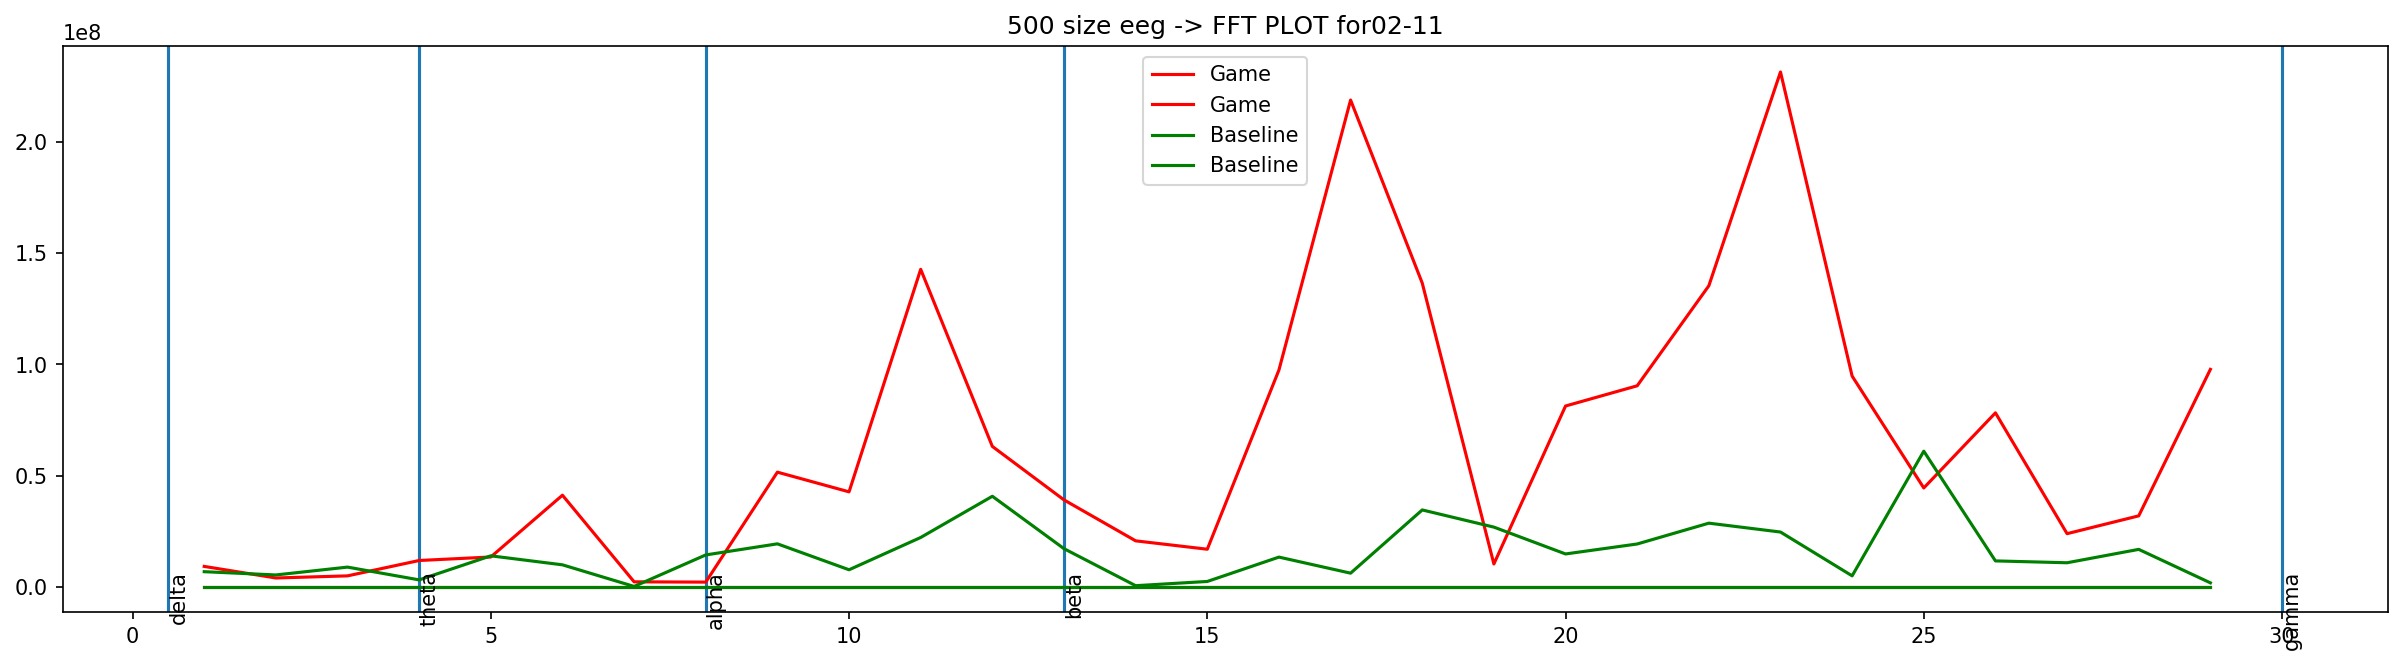

Date 06-11


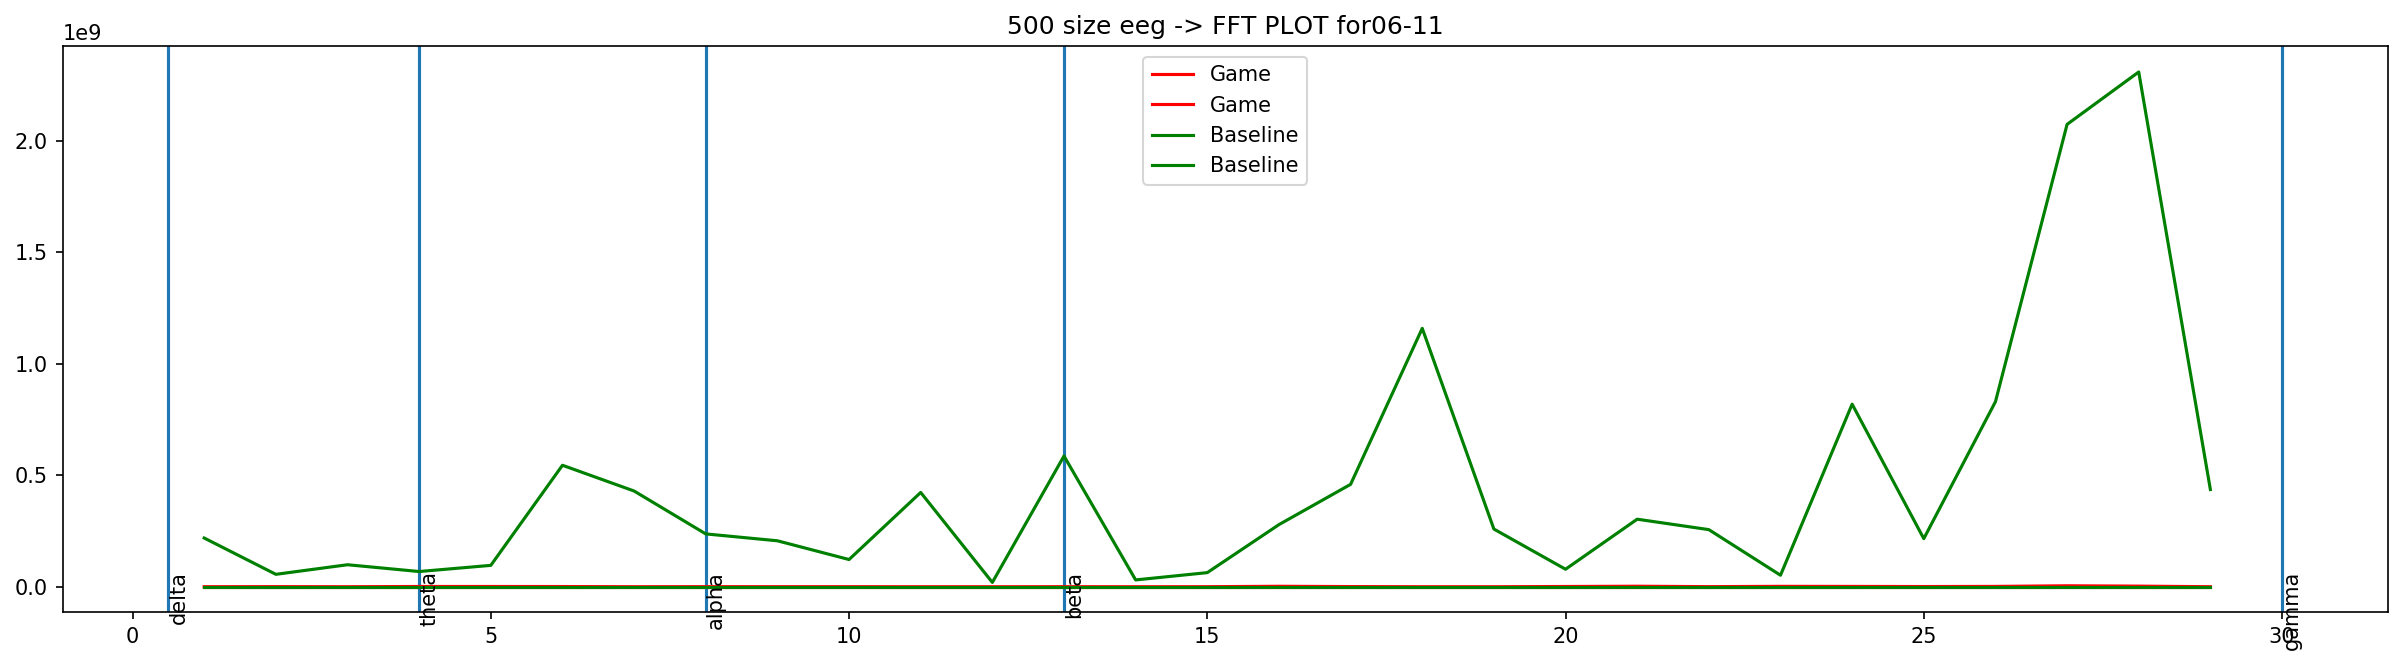

Date 0616-10


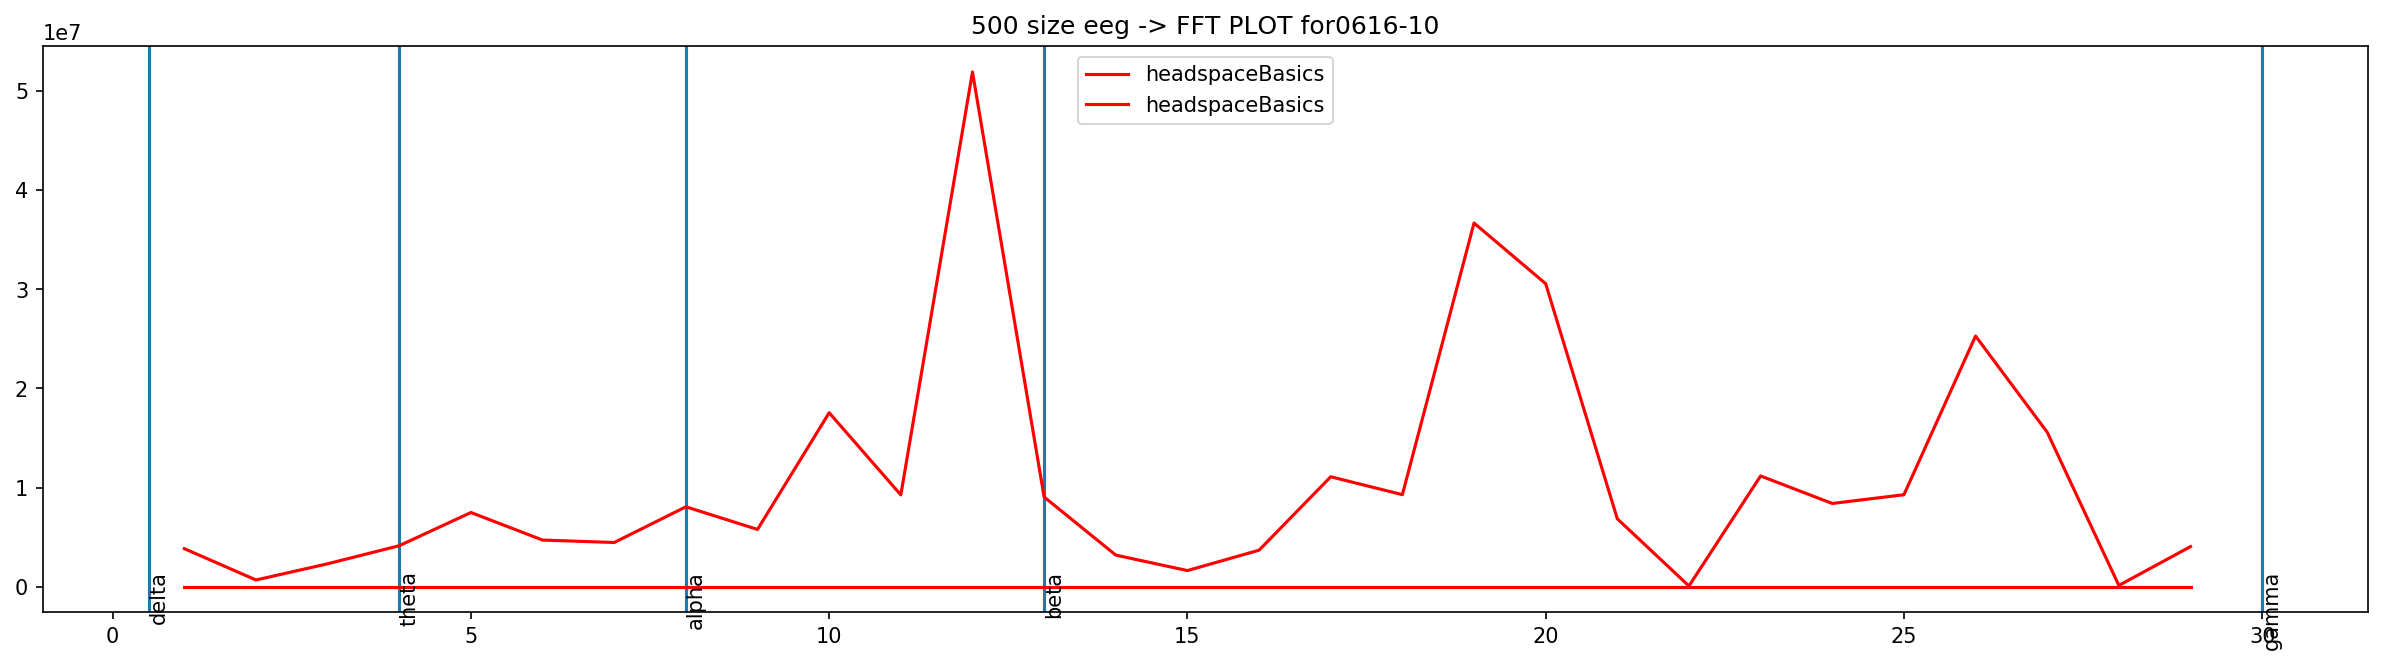

Date 07-11


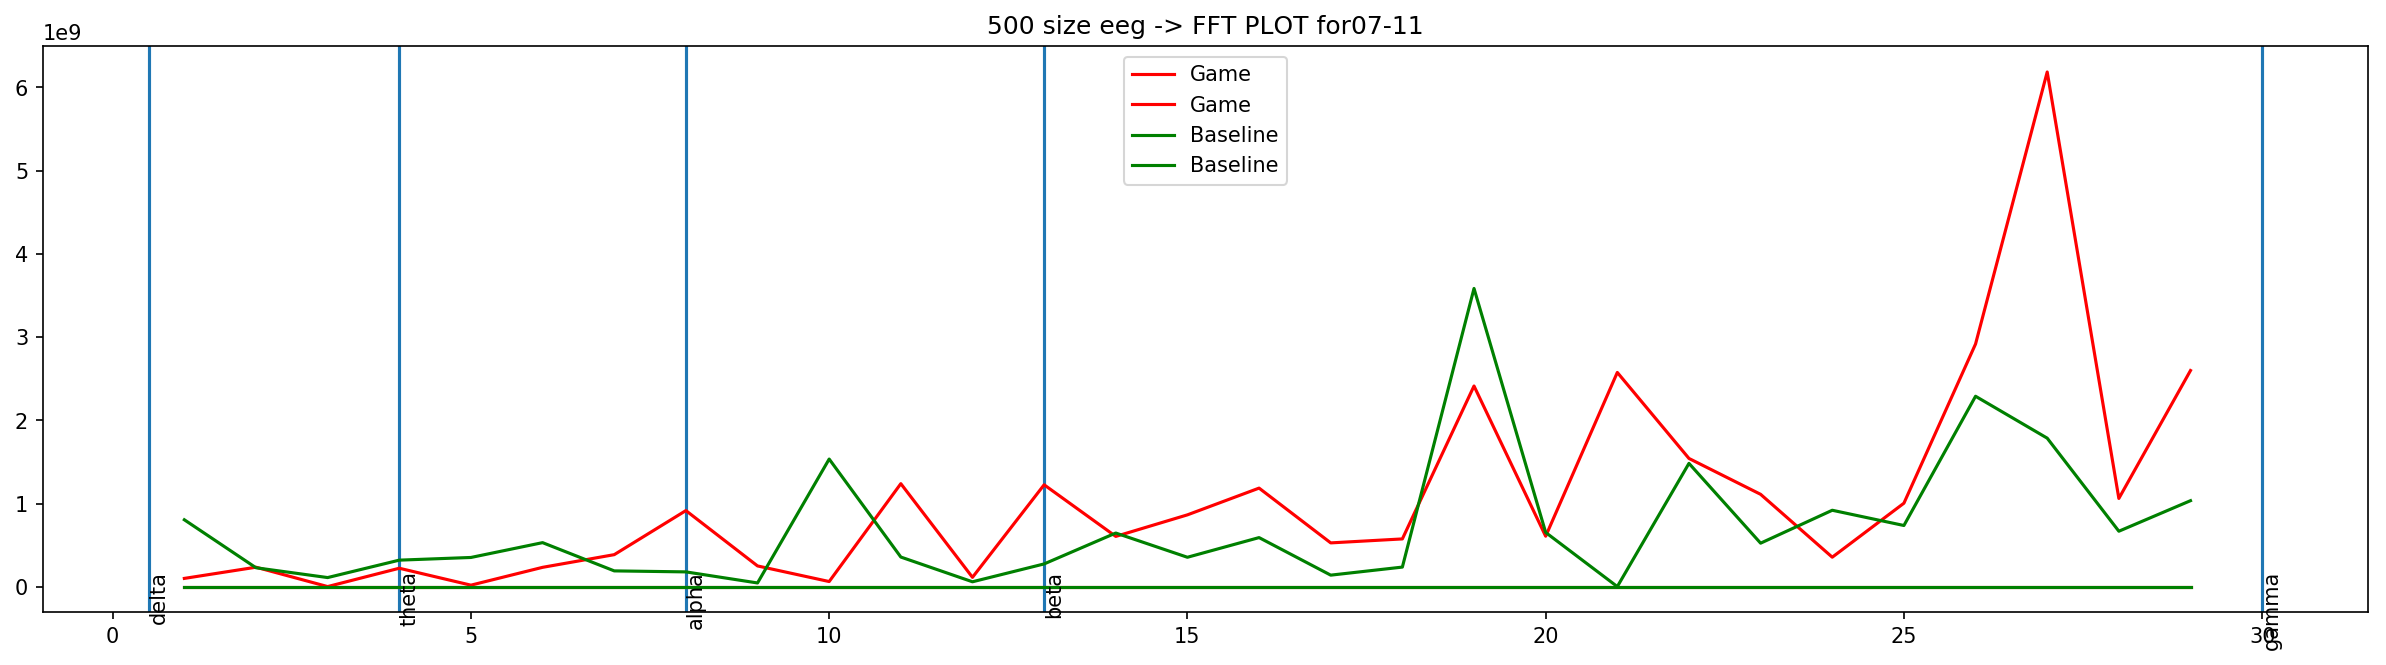

Date 08-10


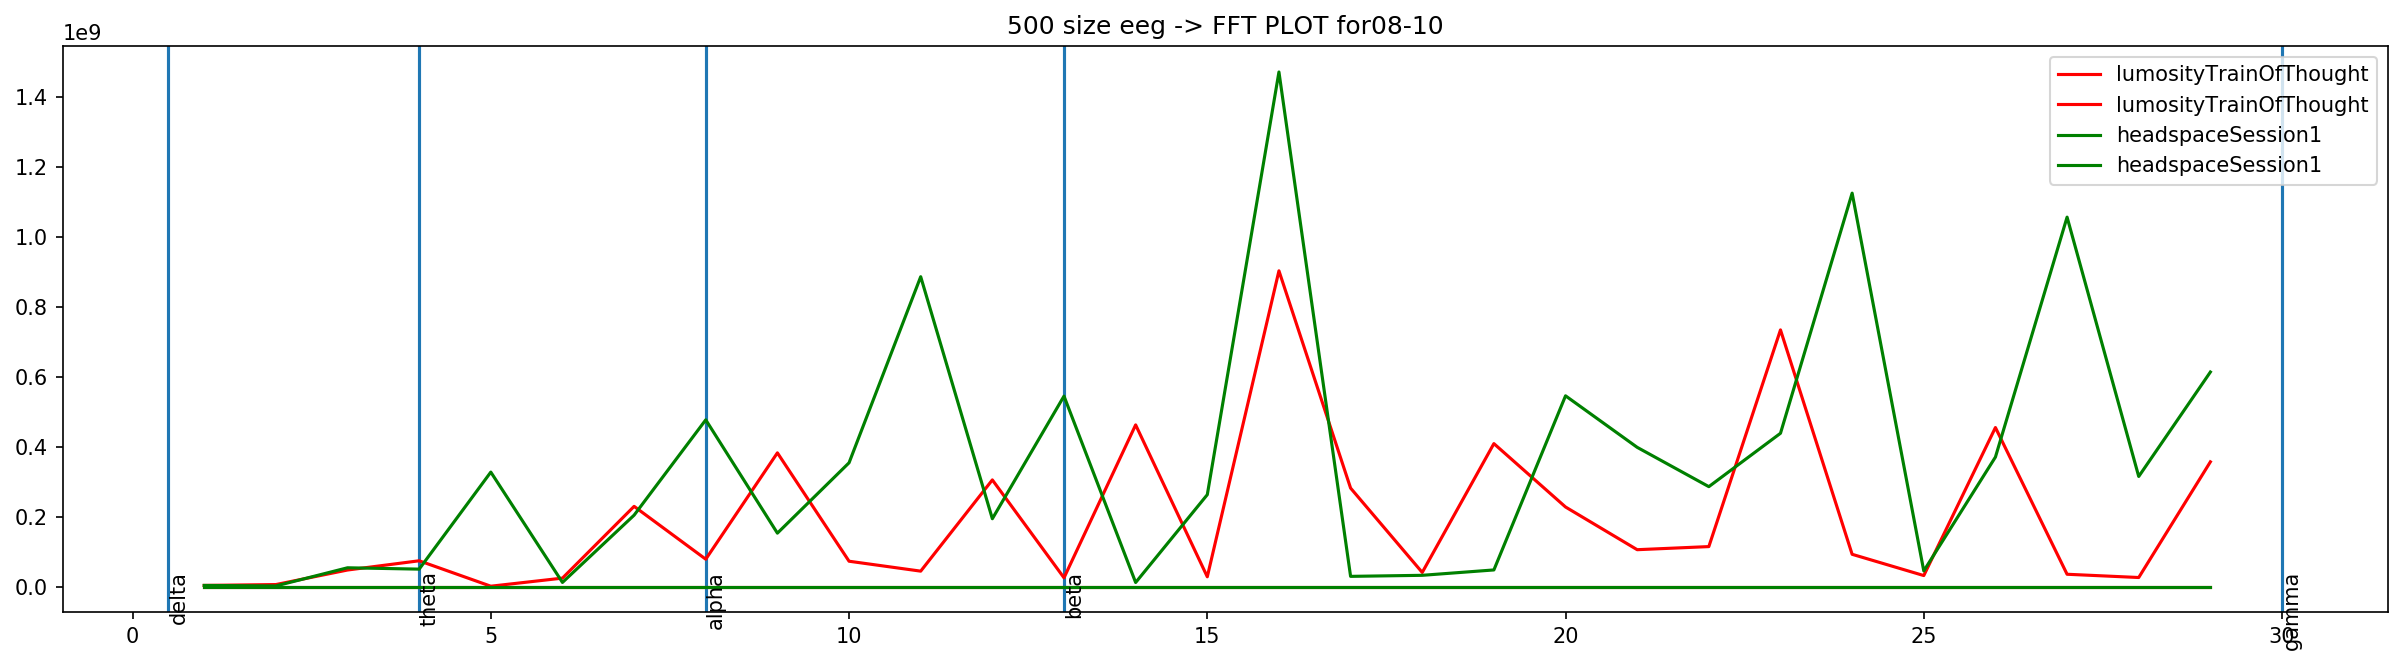

Date 09-10


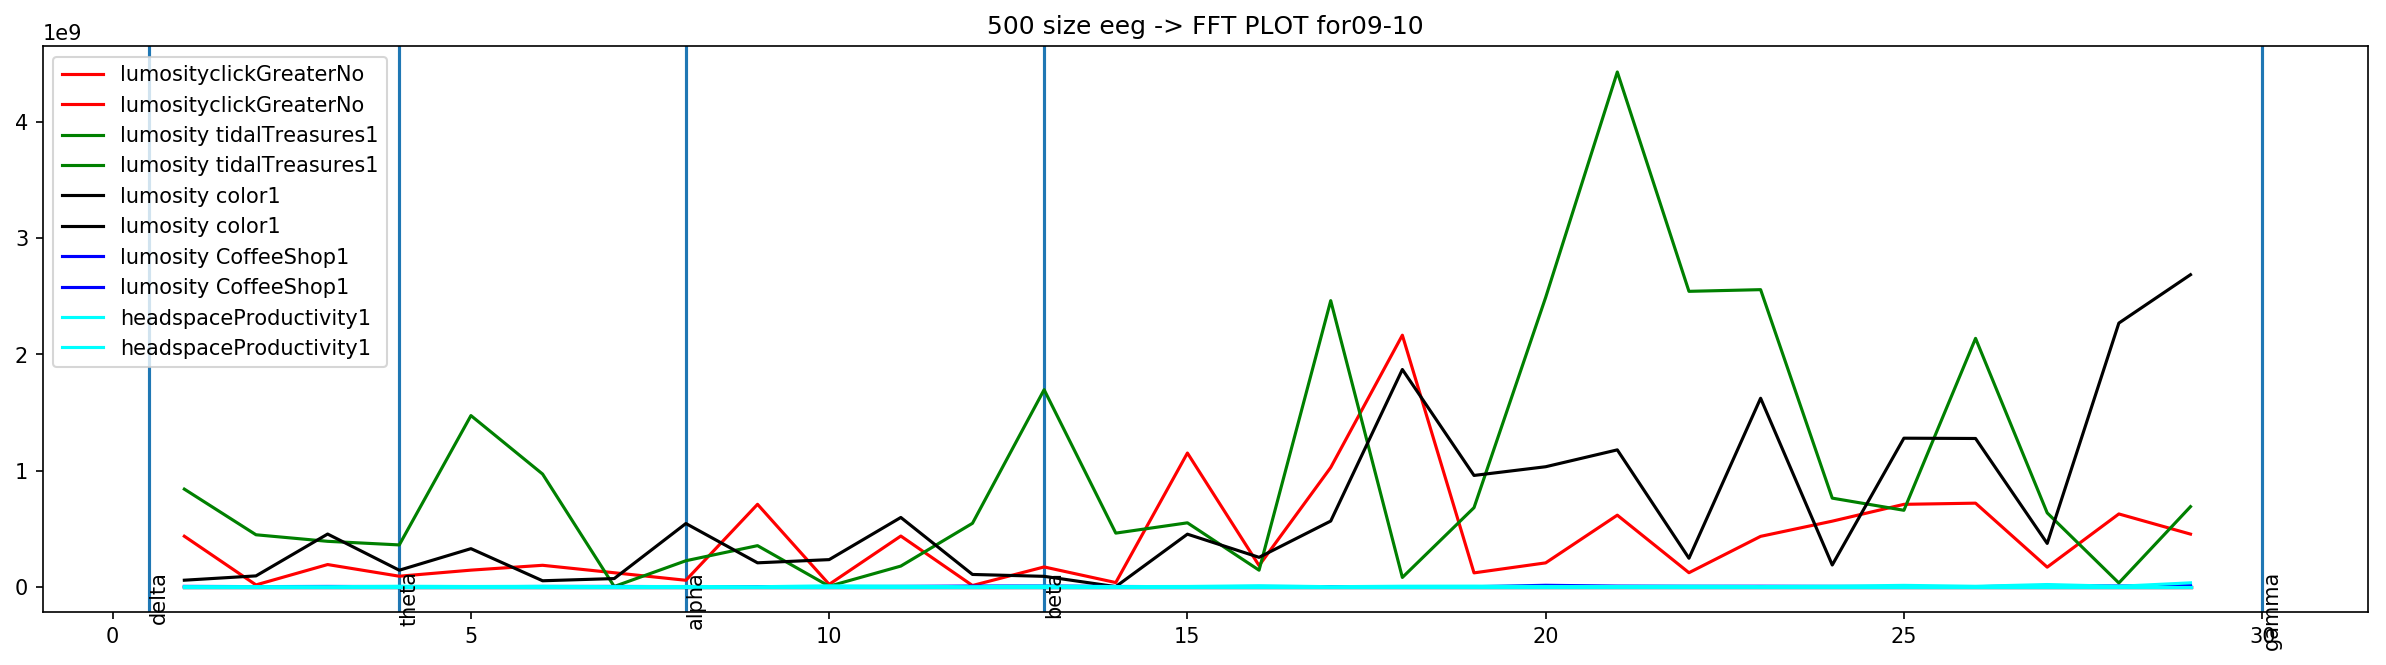

Date 10-10


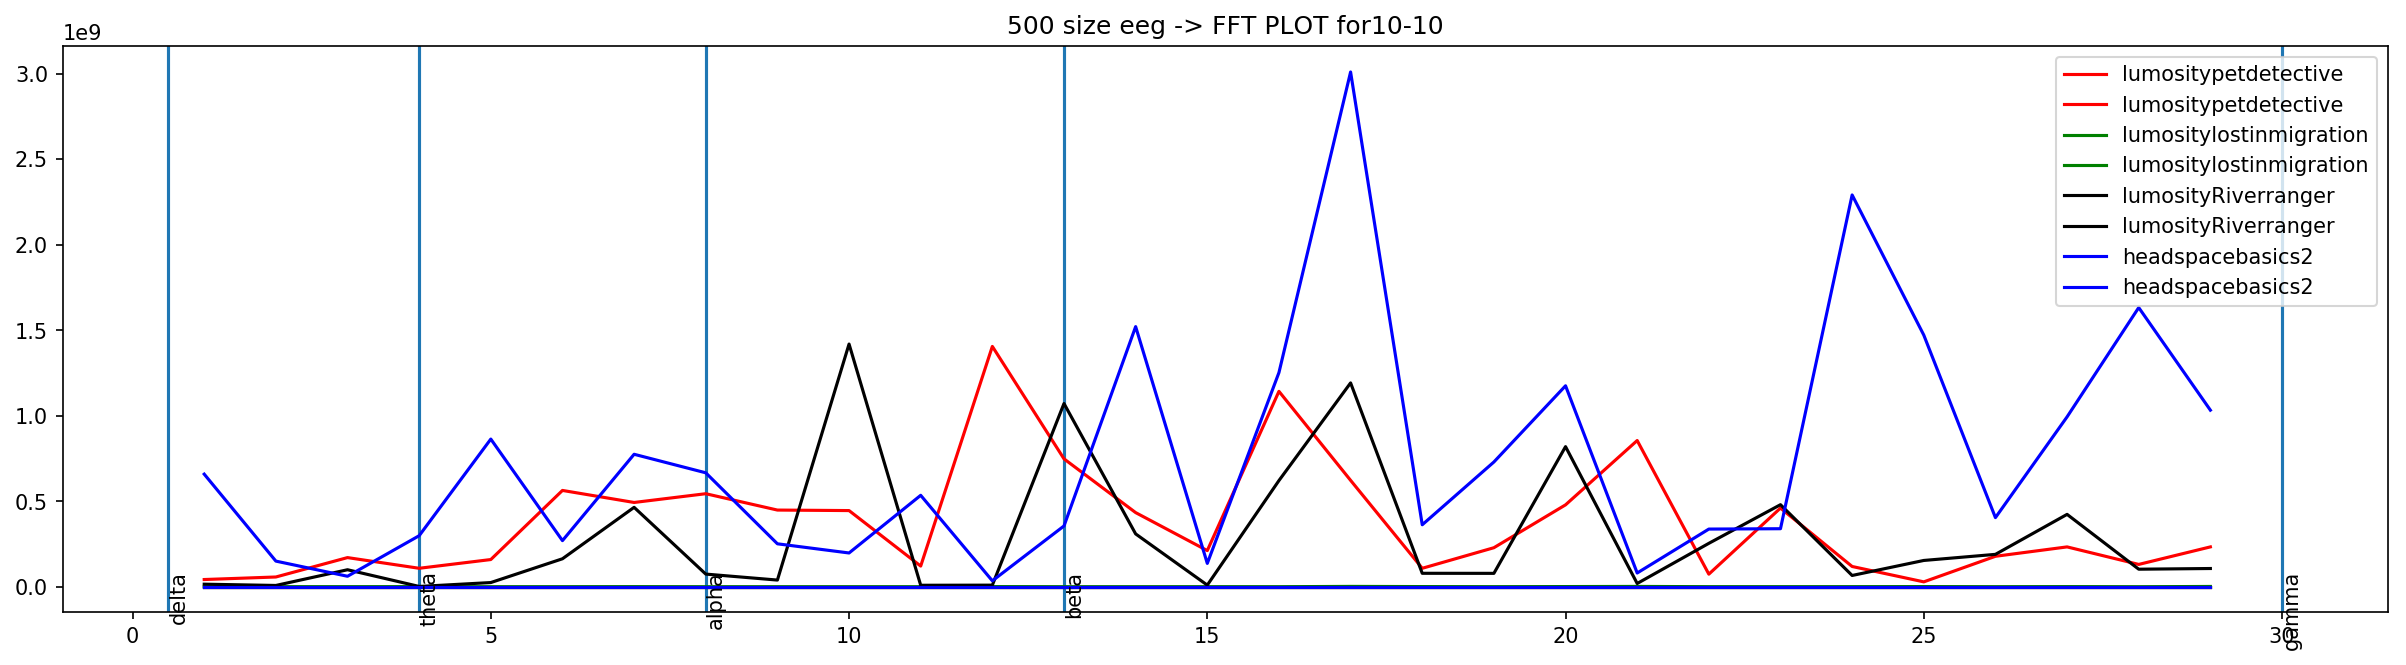

Date 10-11


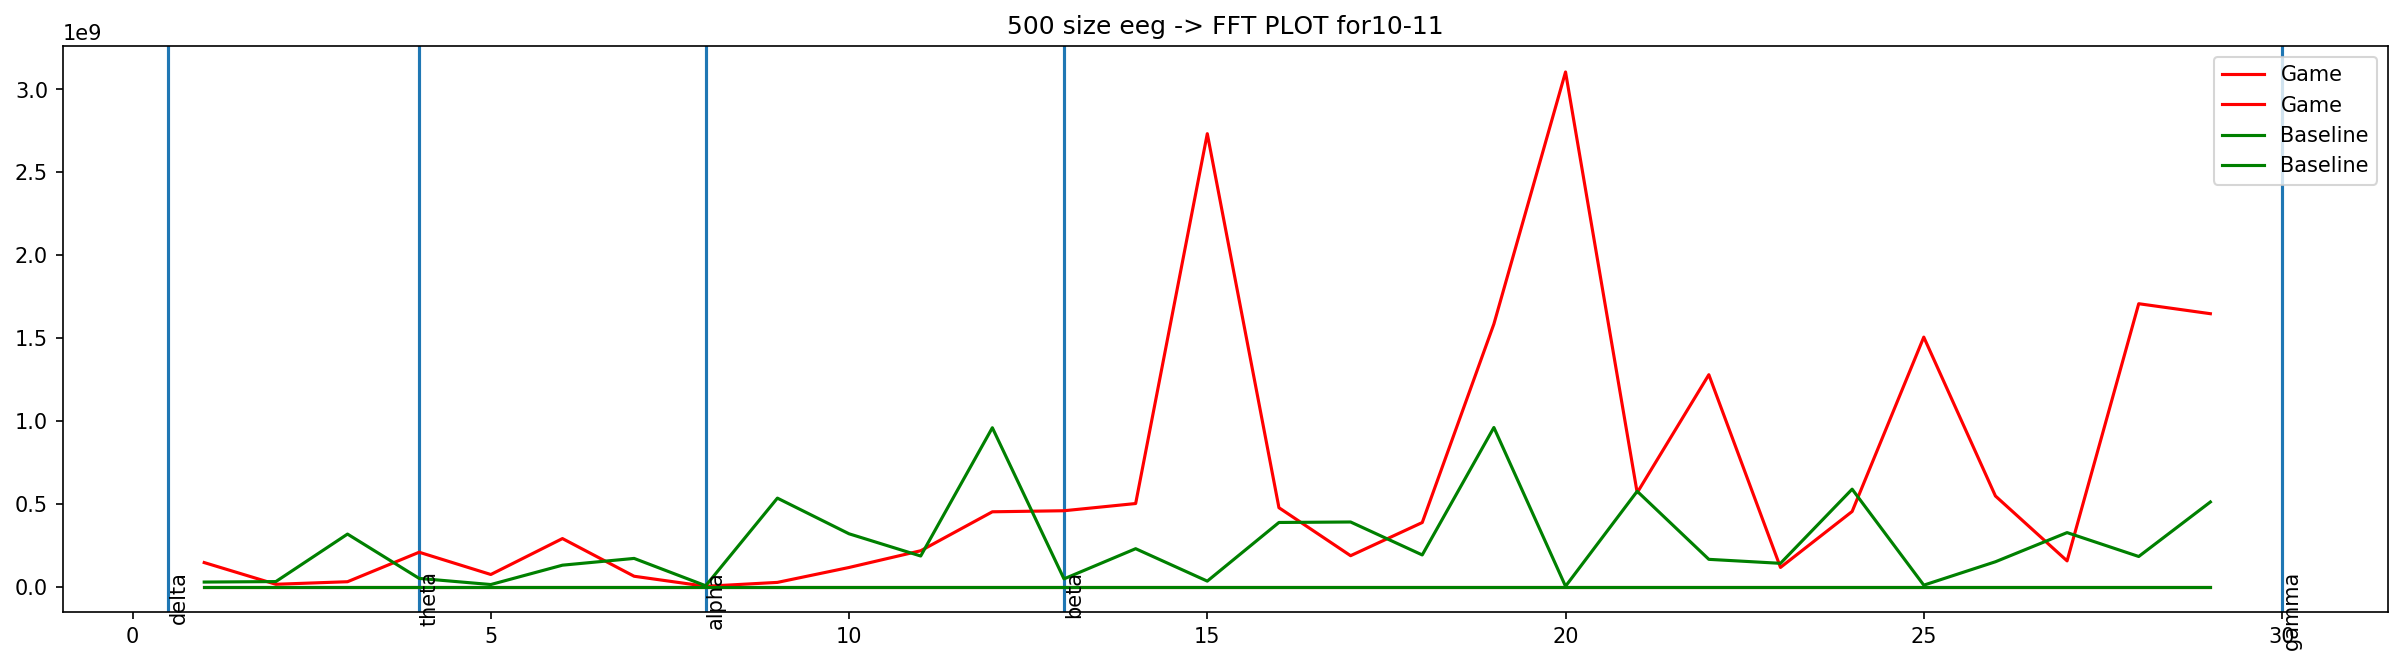

Date 11-10


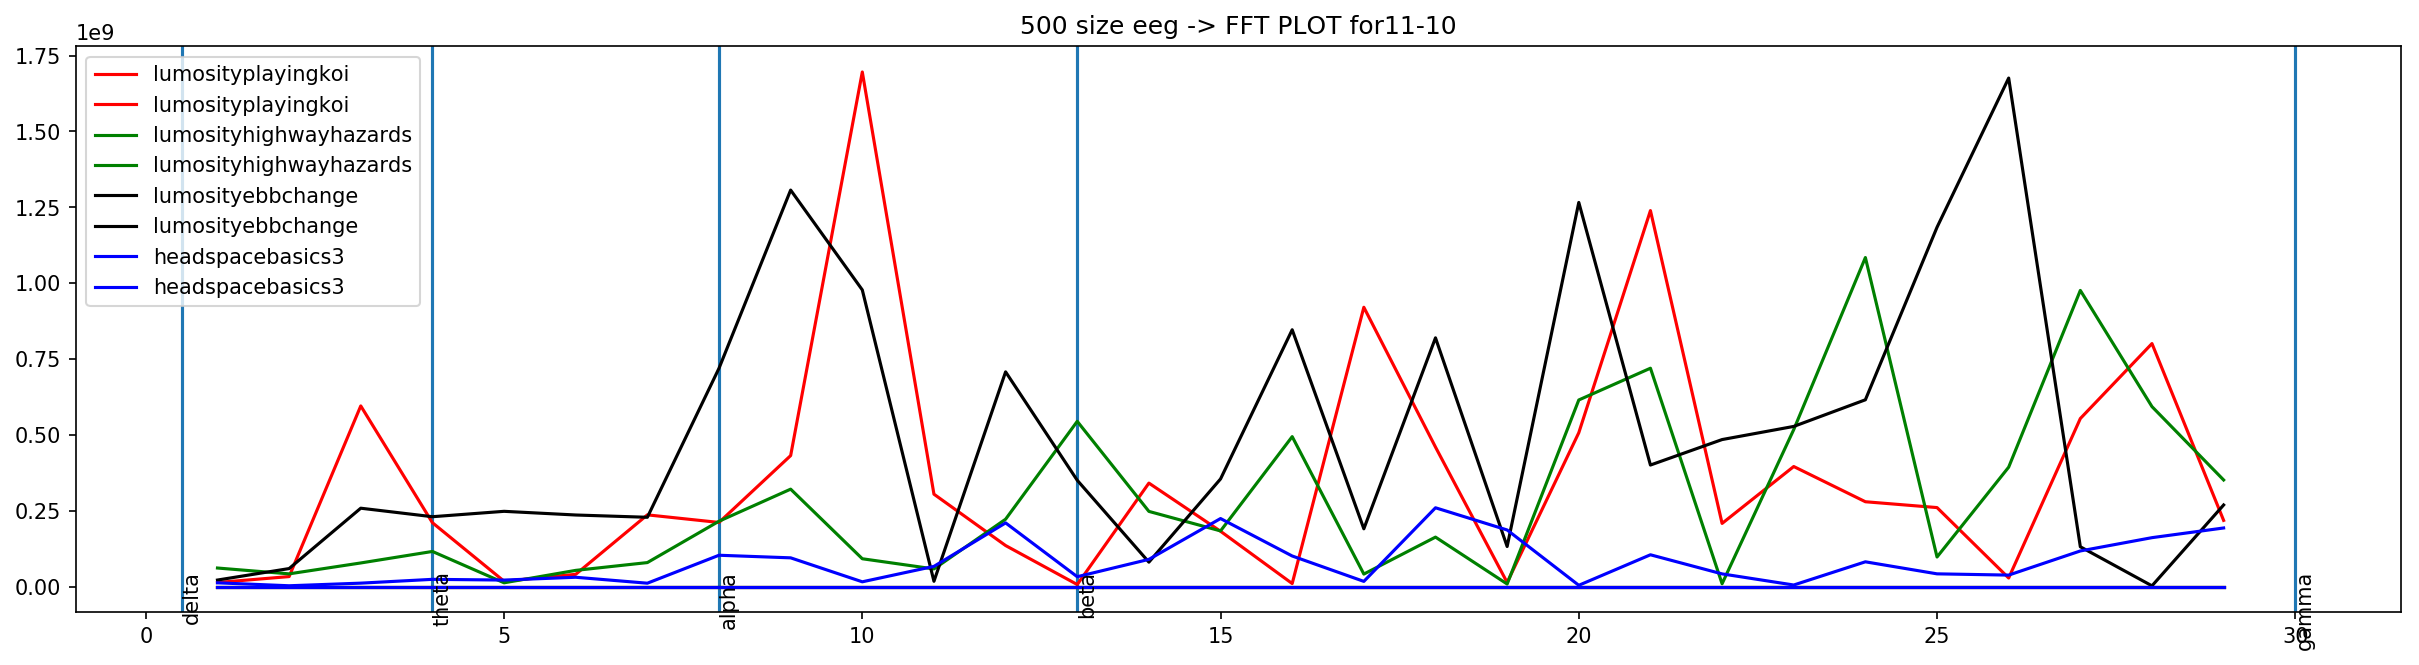

Date 12-10


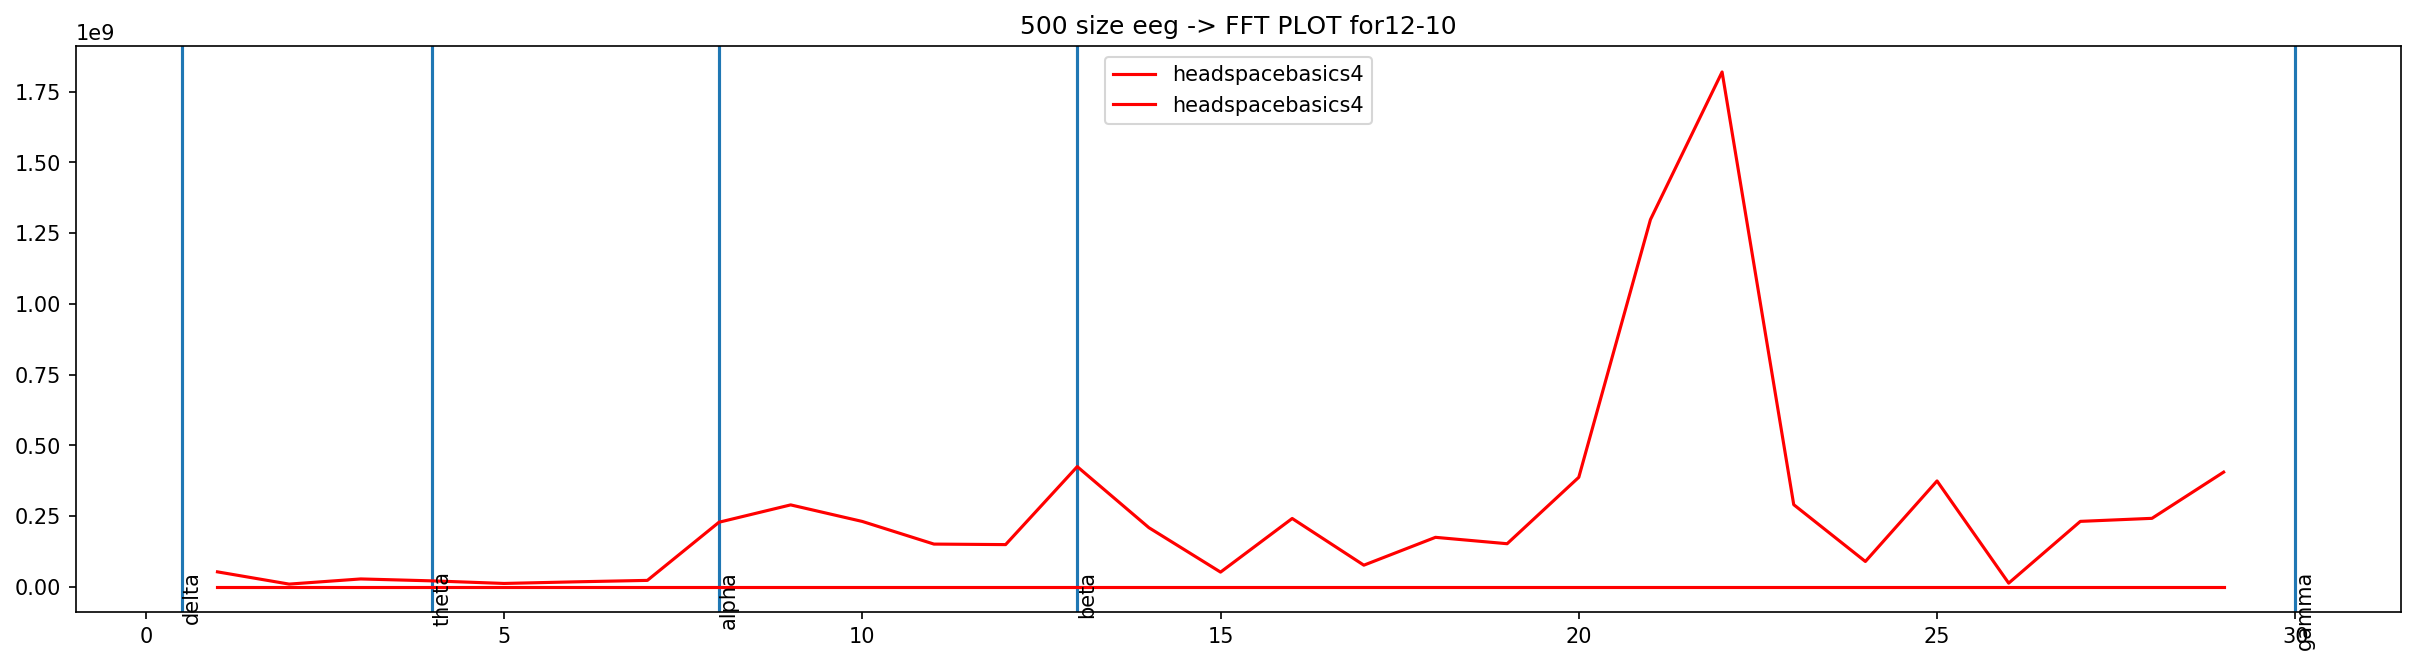

Date 12-11


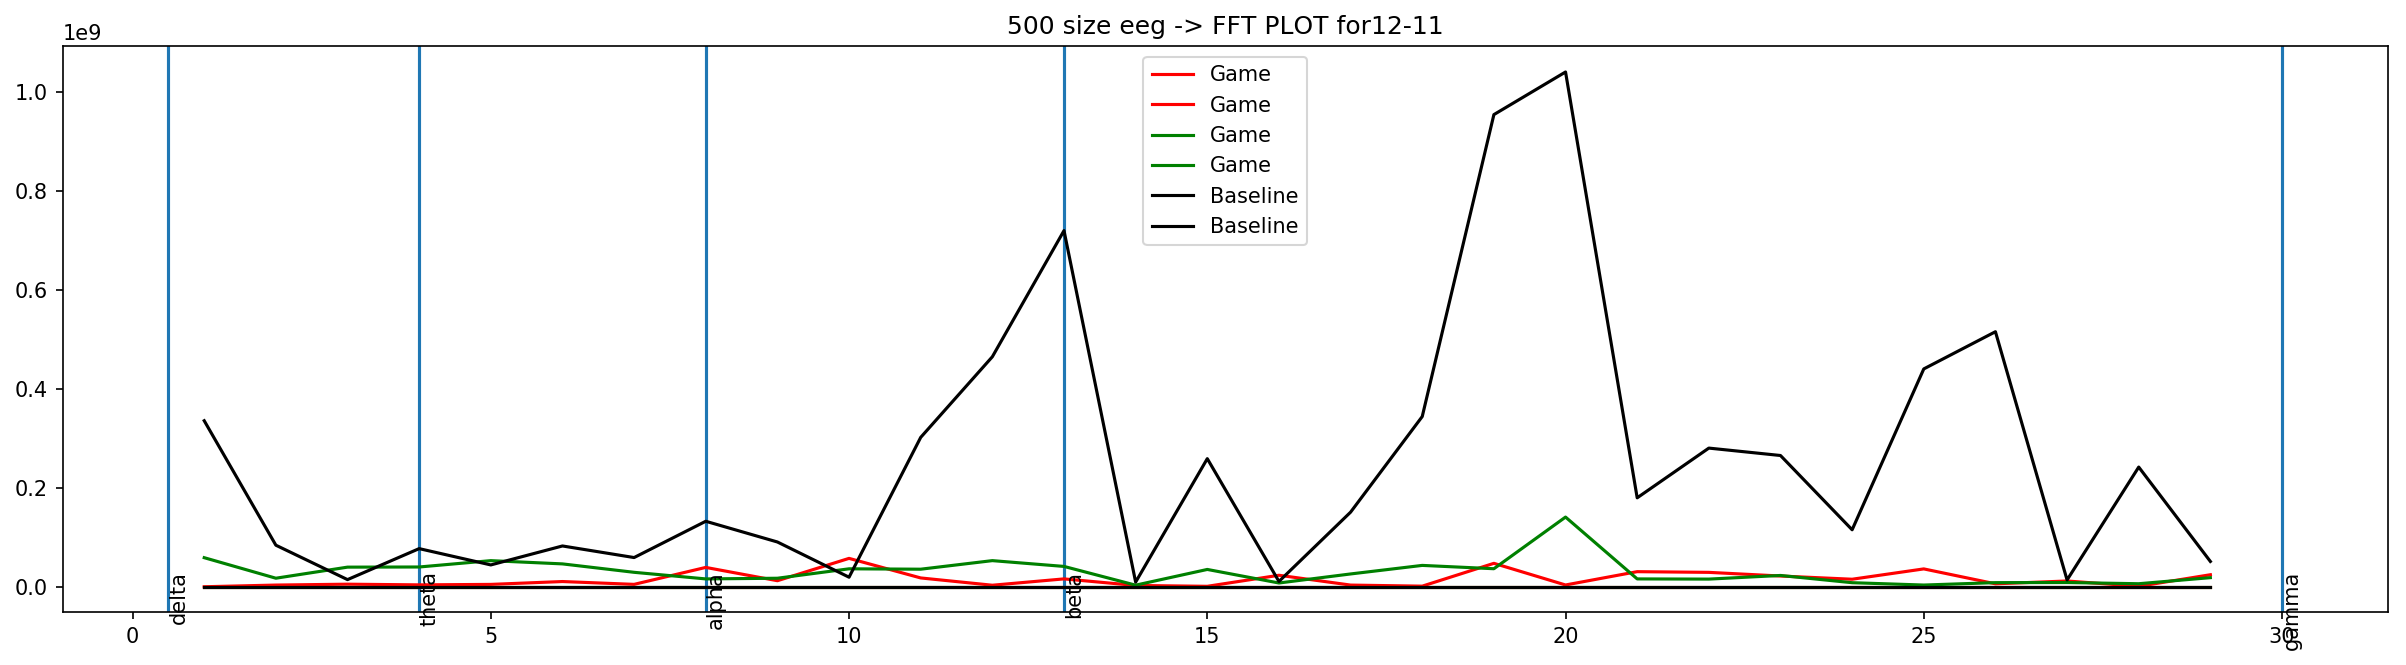

Date 13-10


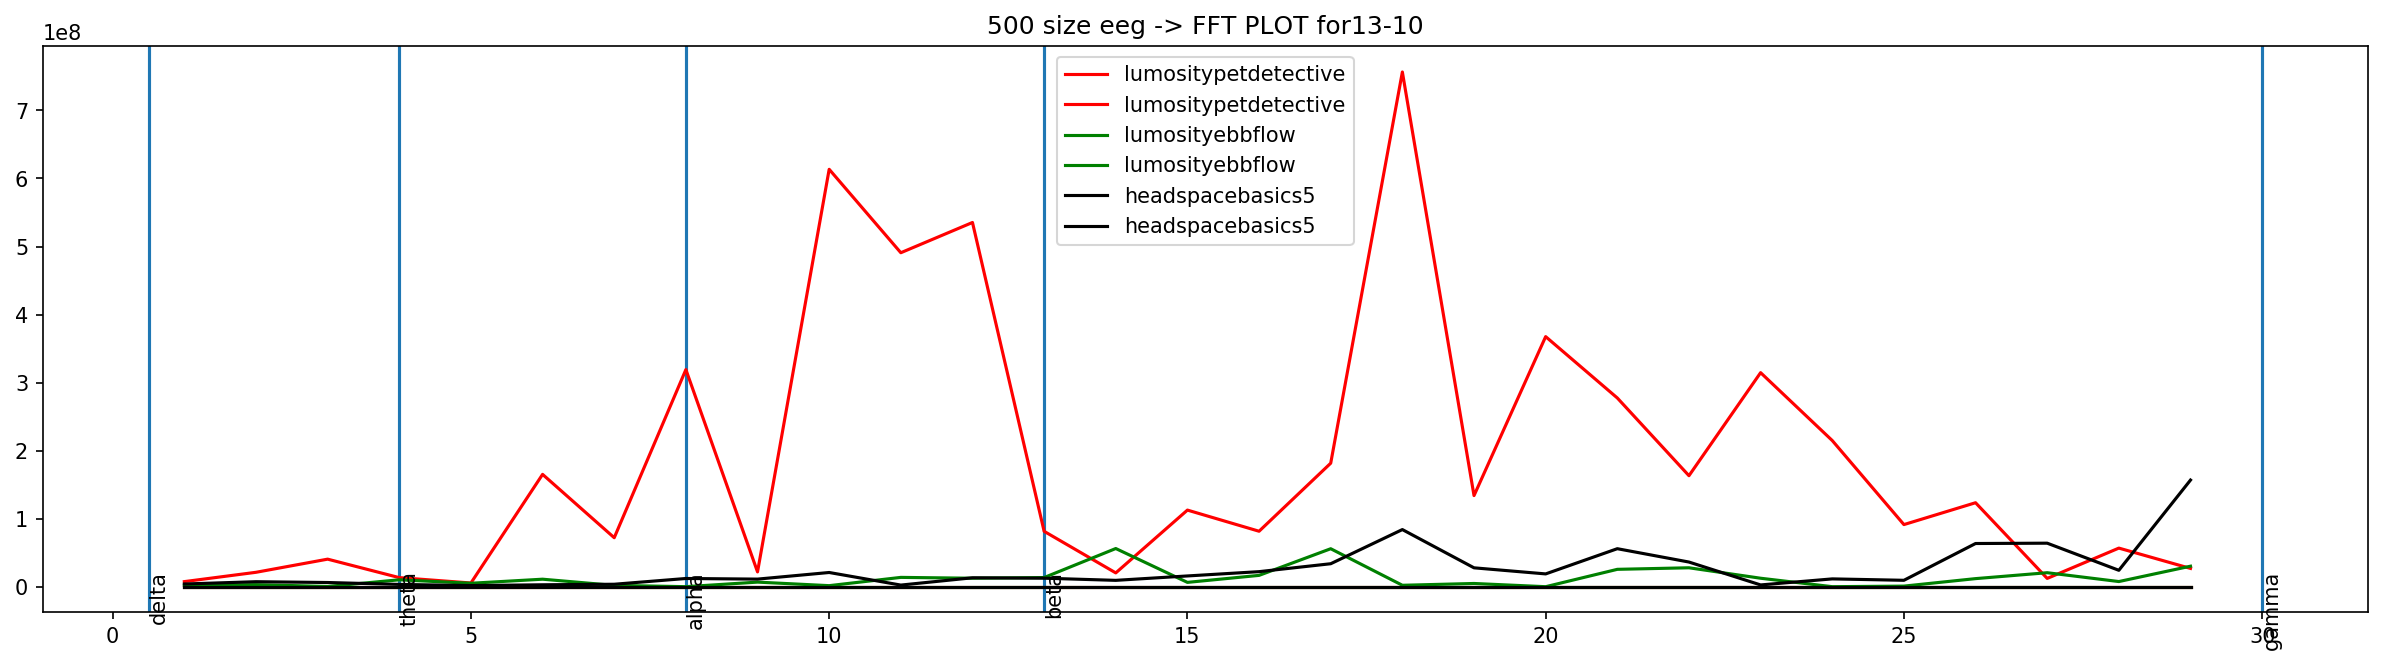

Date 16-10


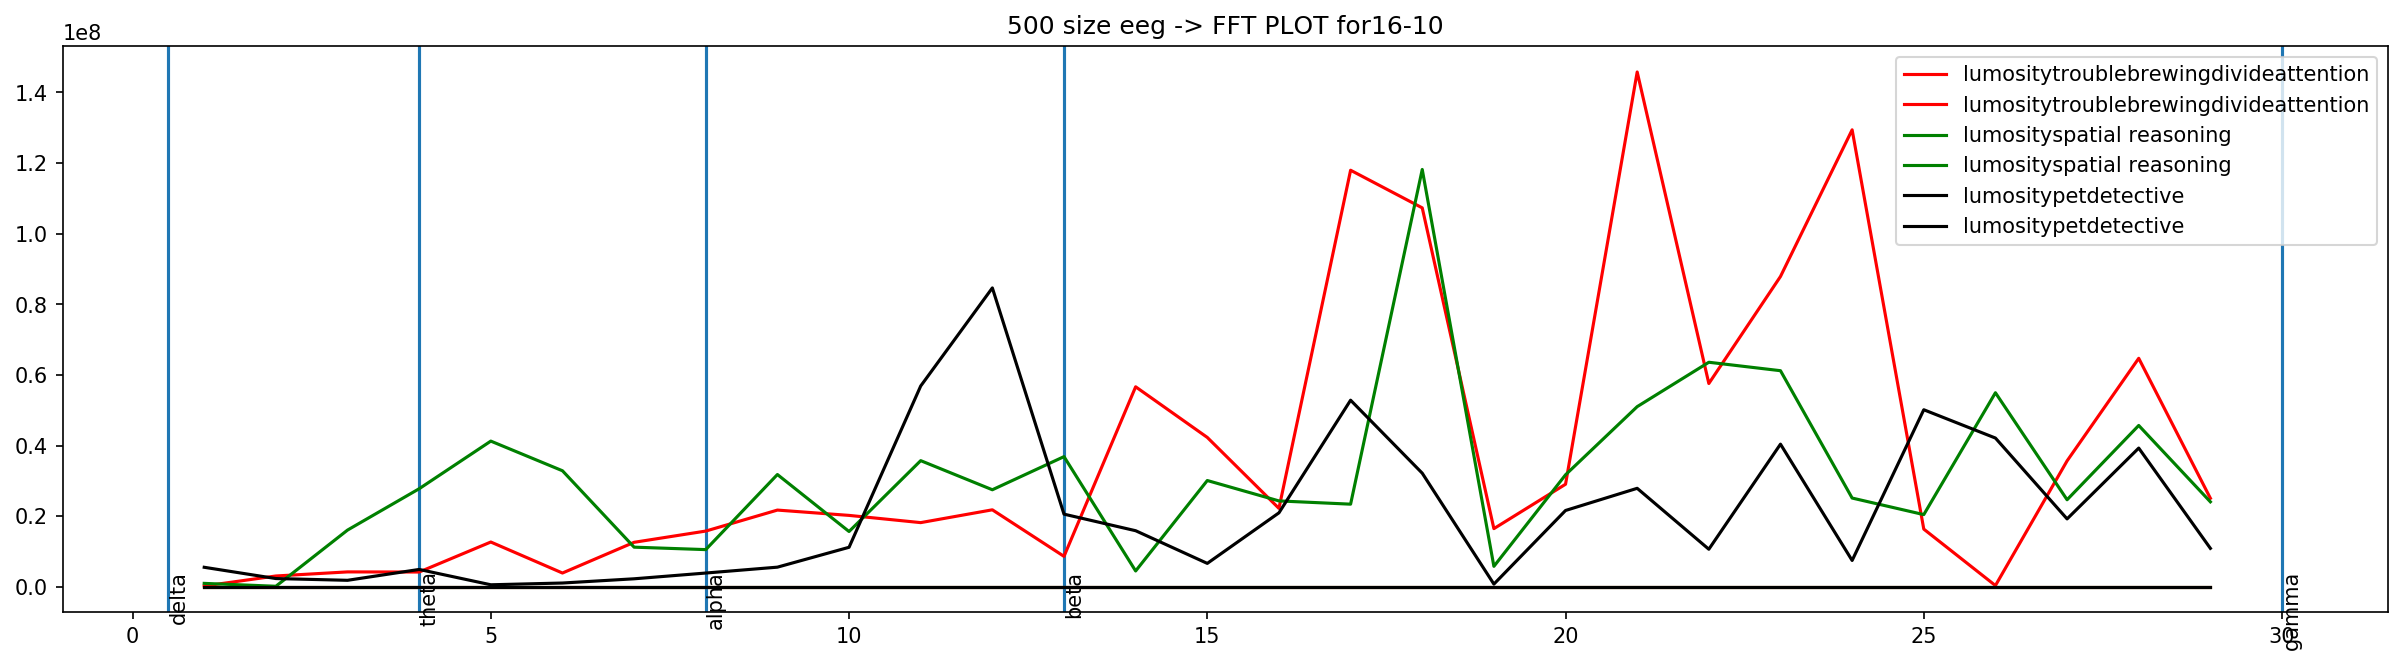

Date 17-39-22.json


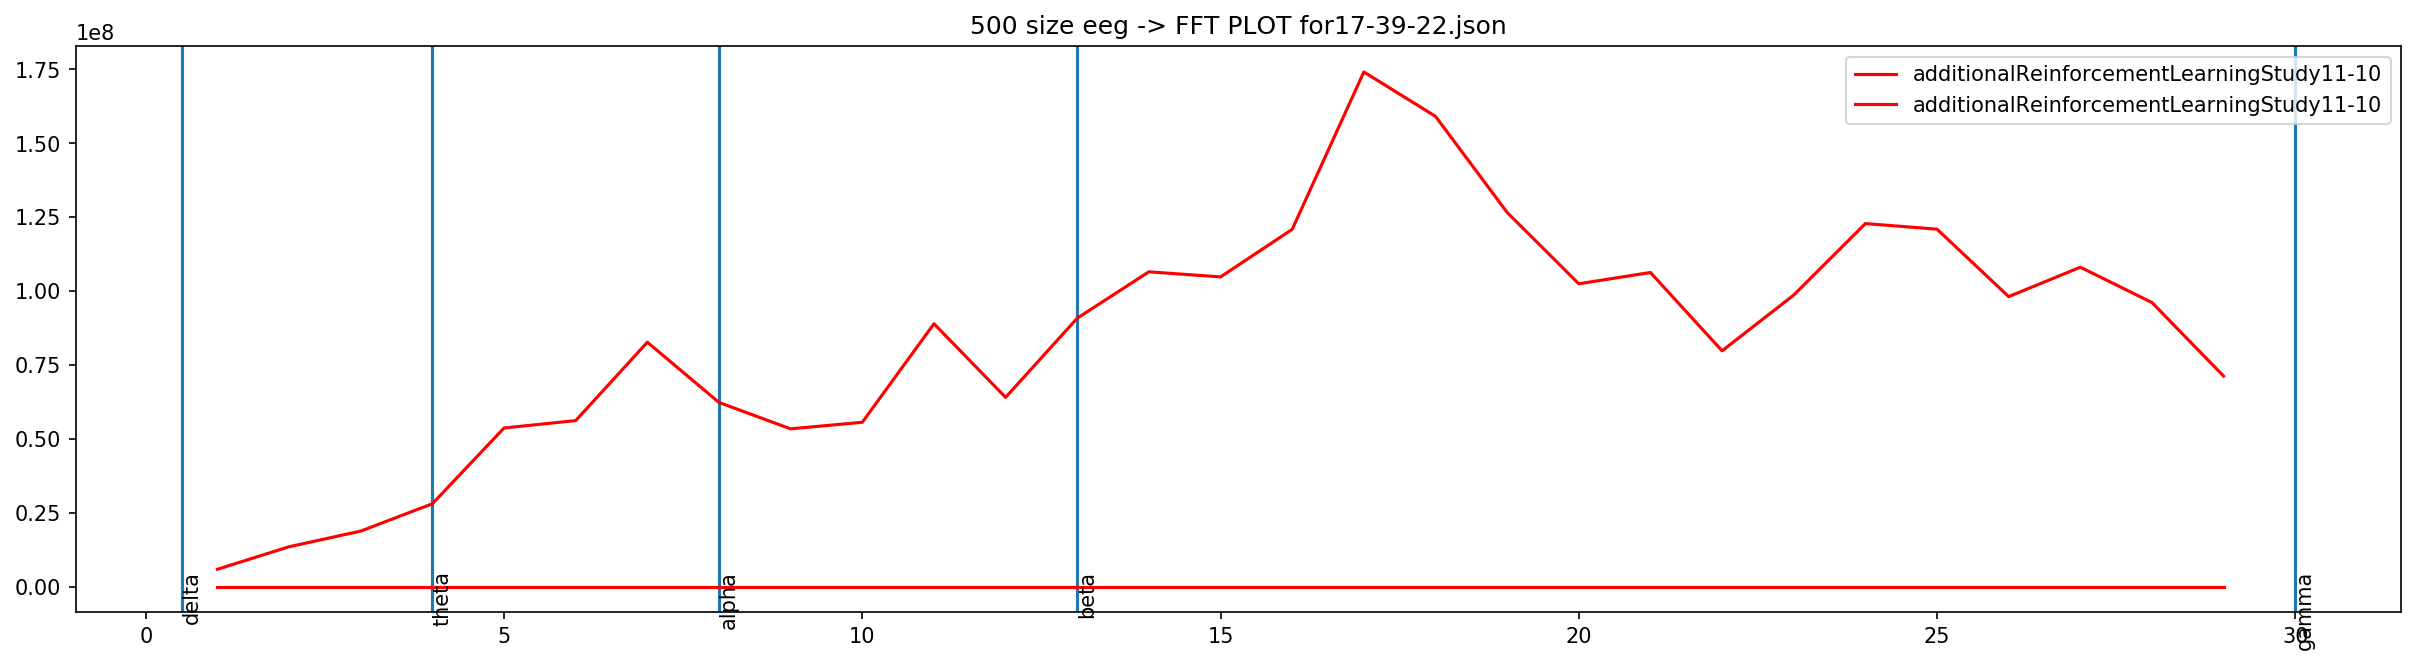

Date 18-10


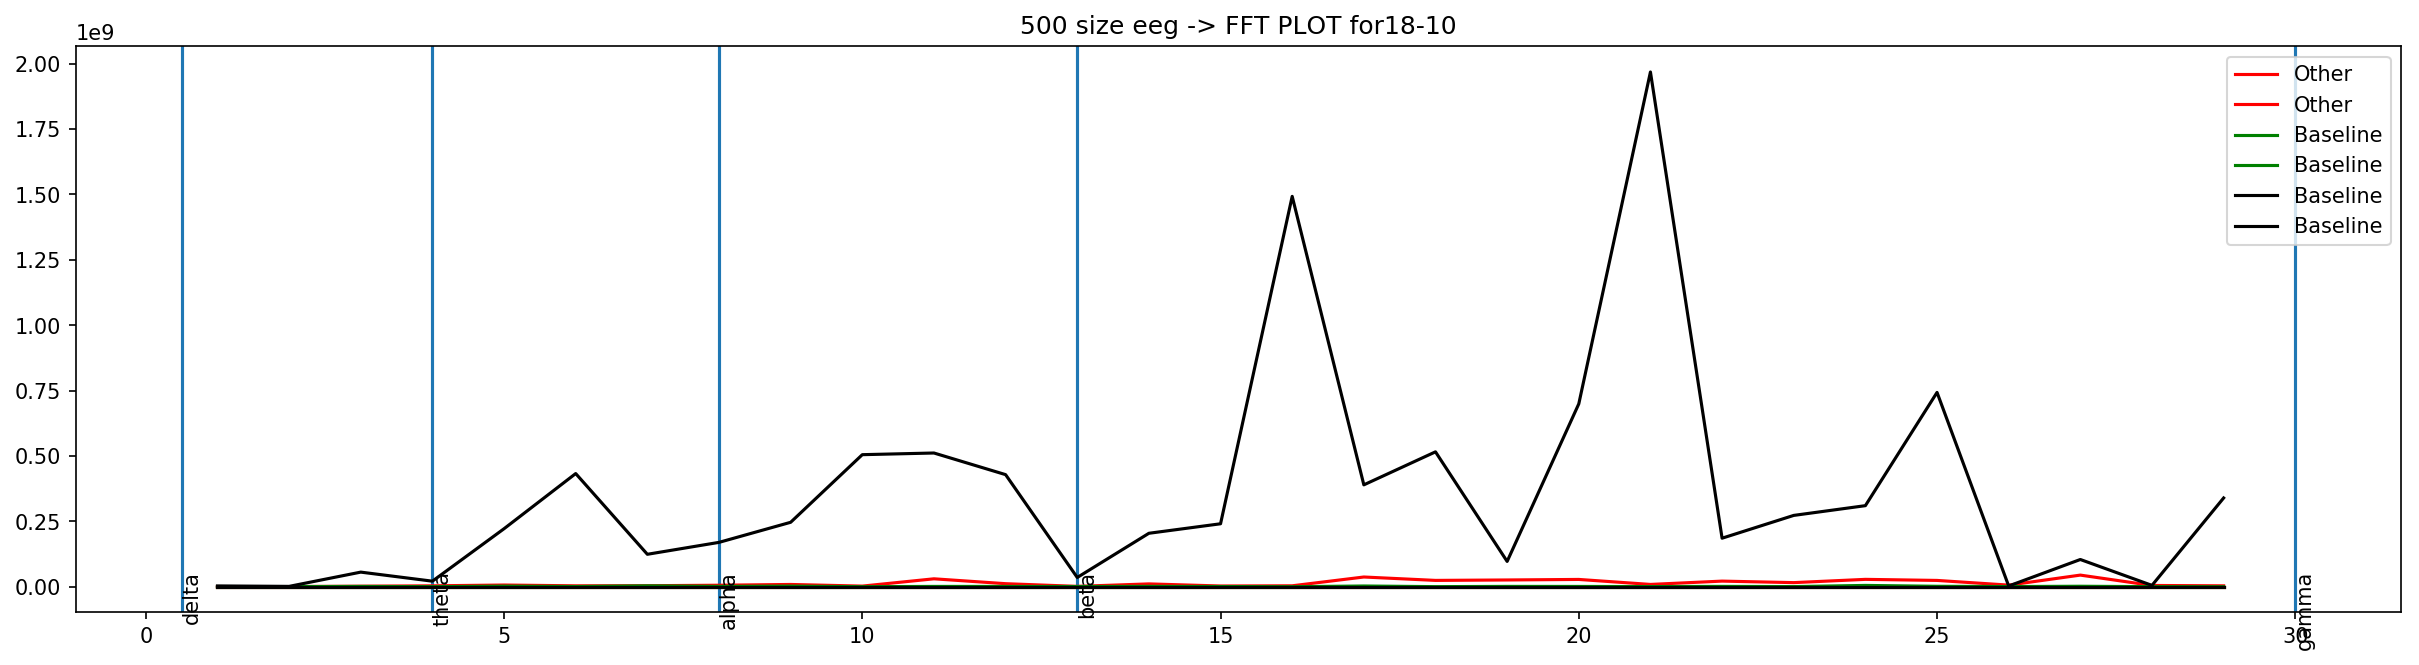

Date 18-40-39.json


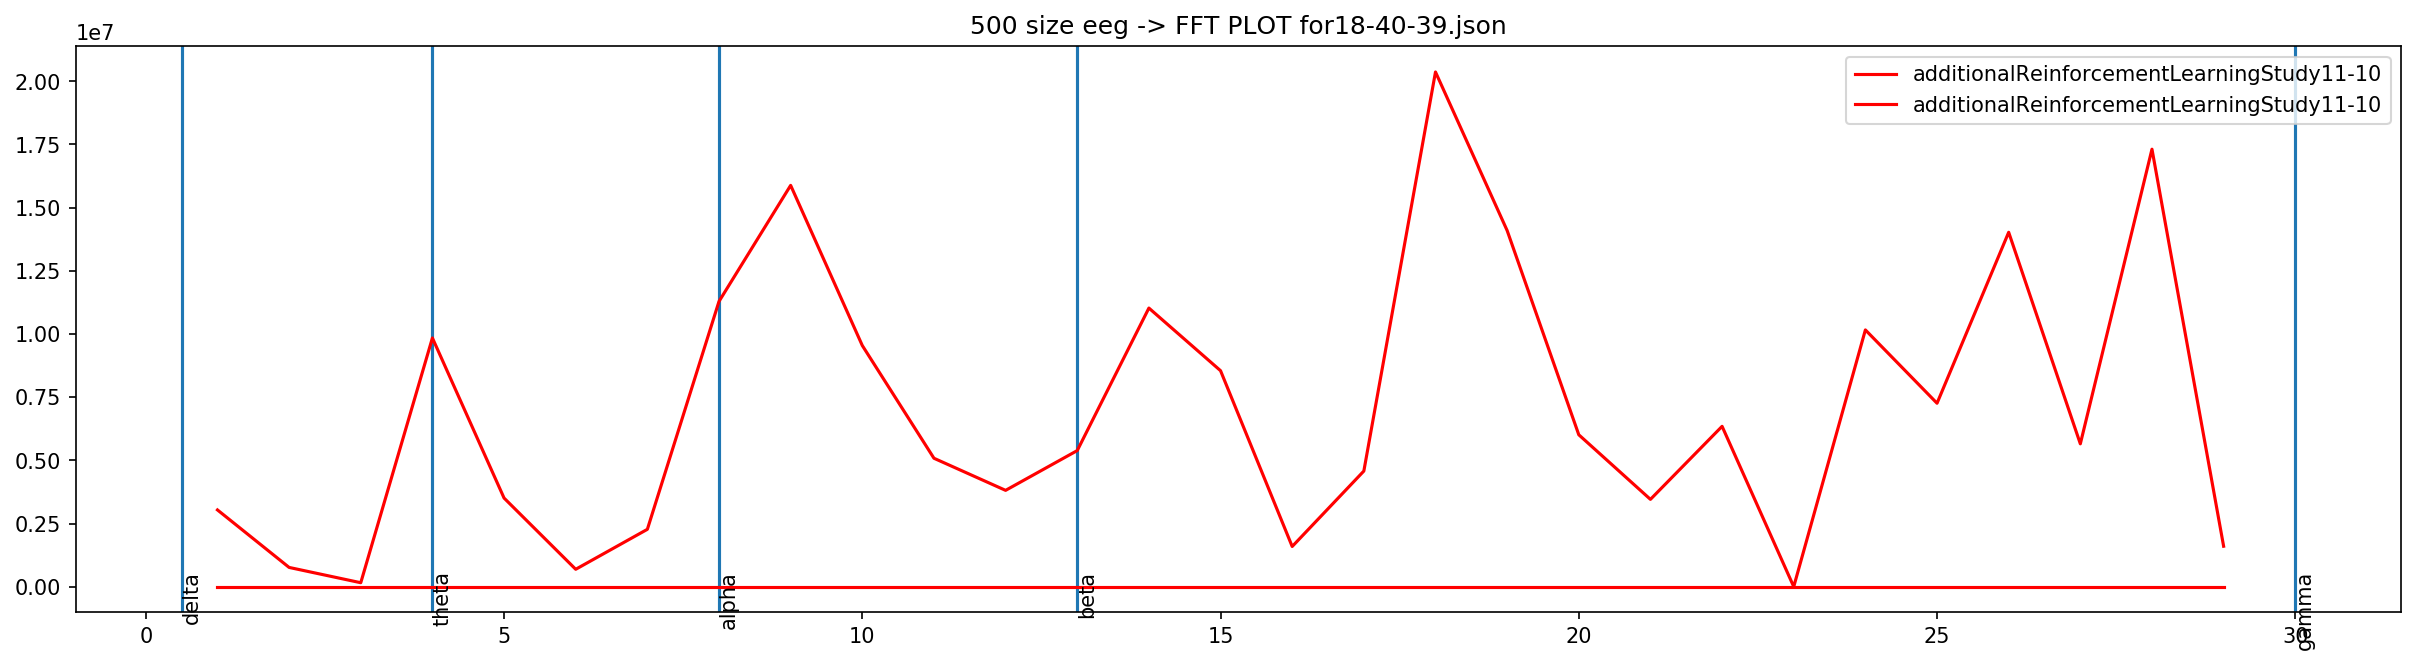

Date 20-10


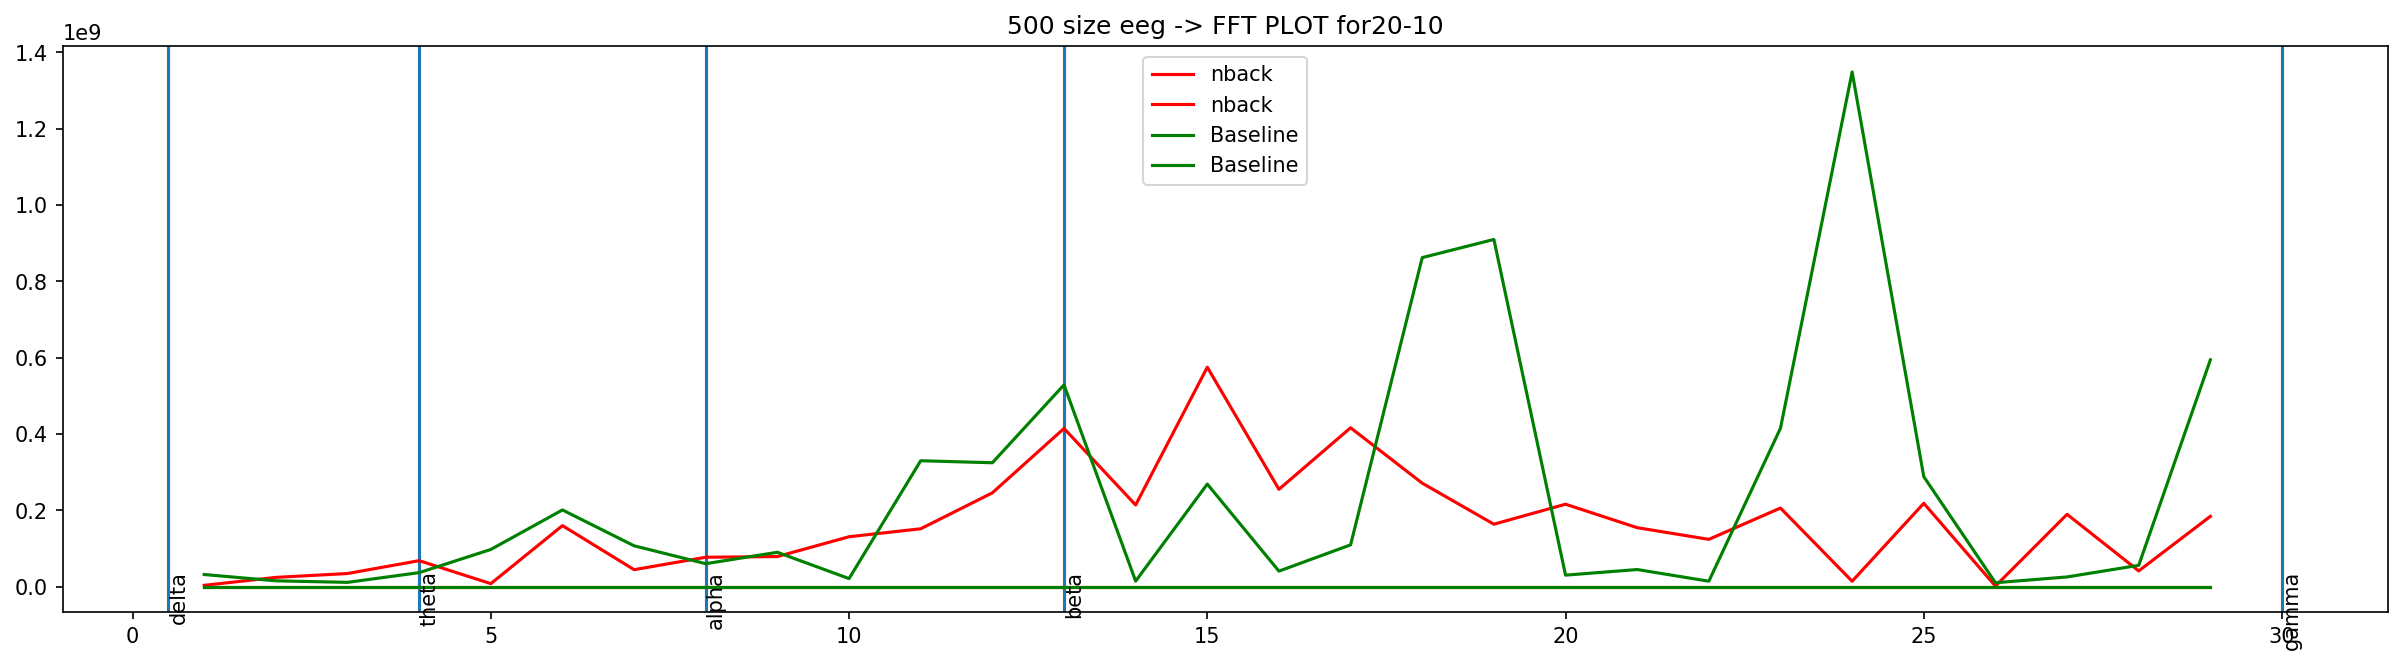

Date 22-10


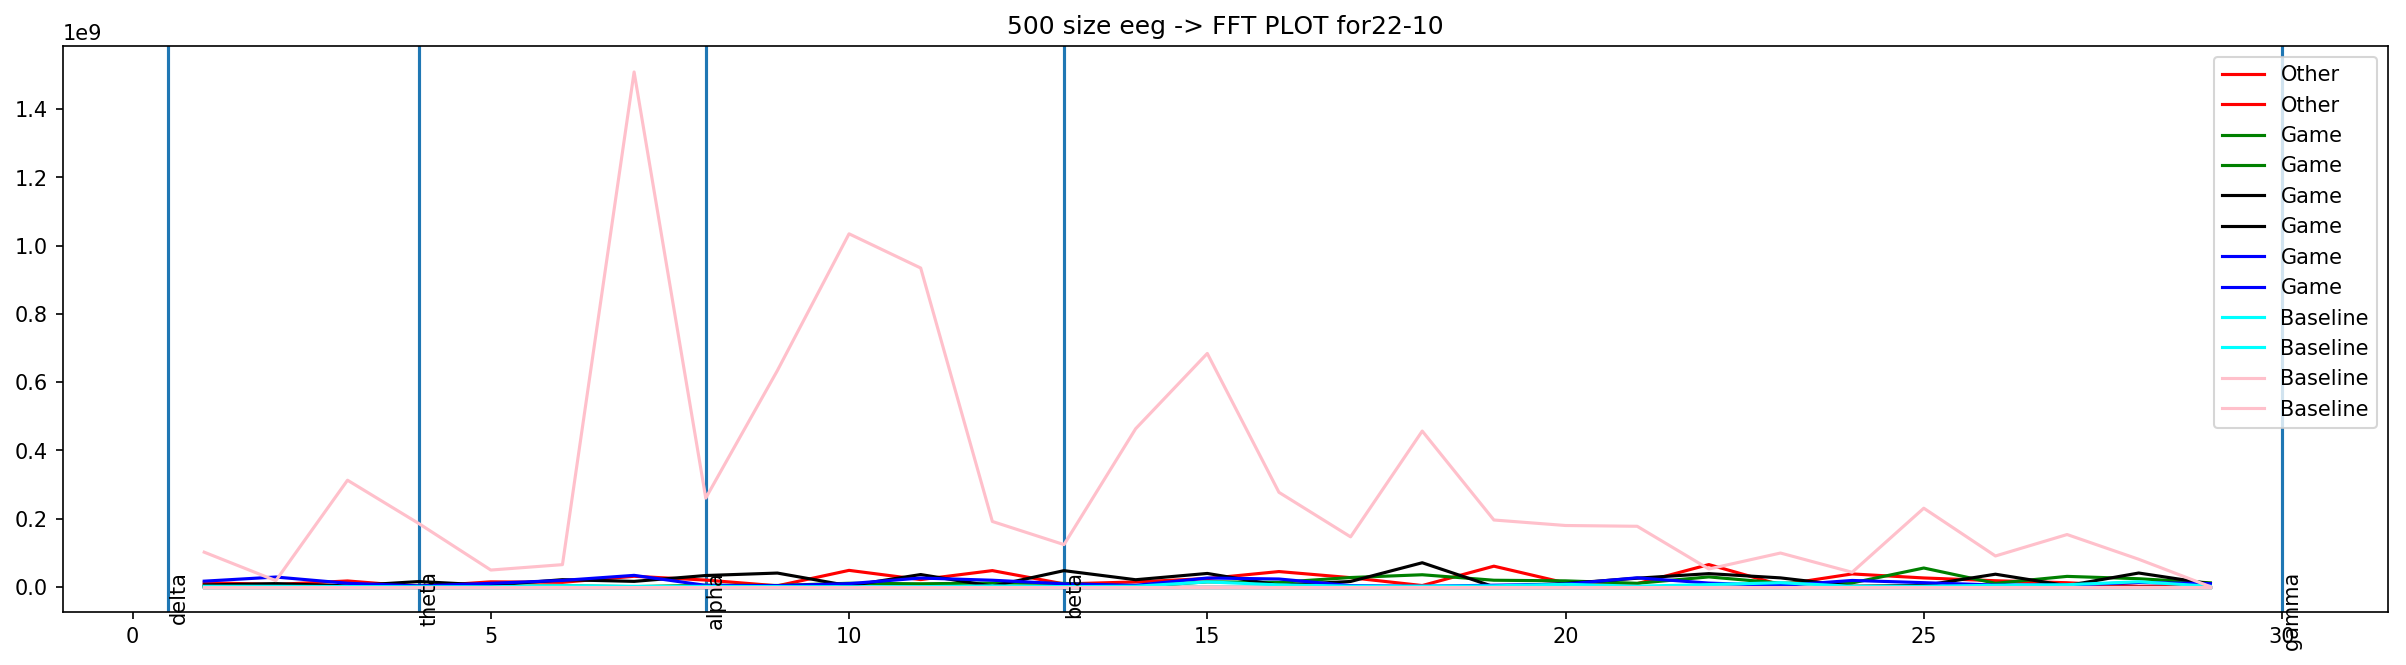

Date 23-10


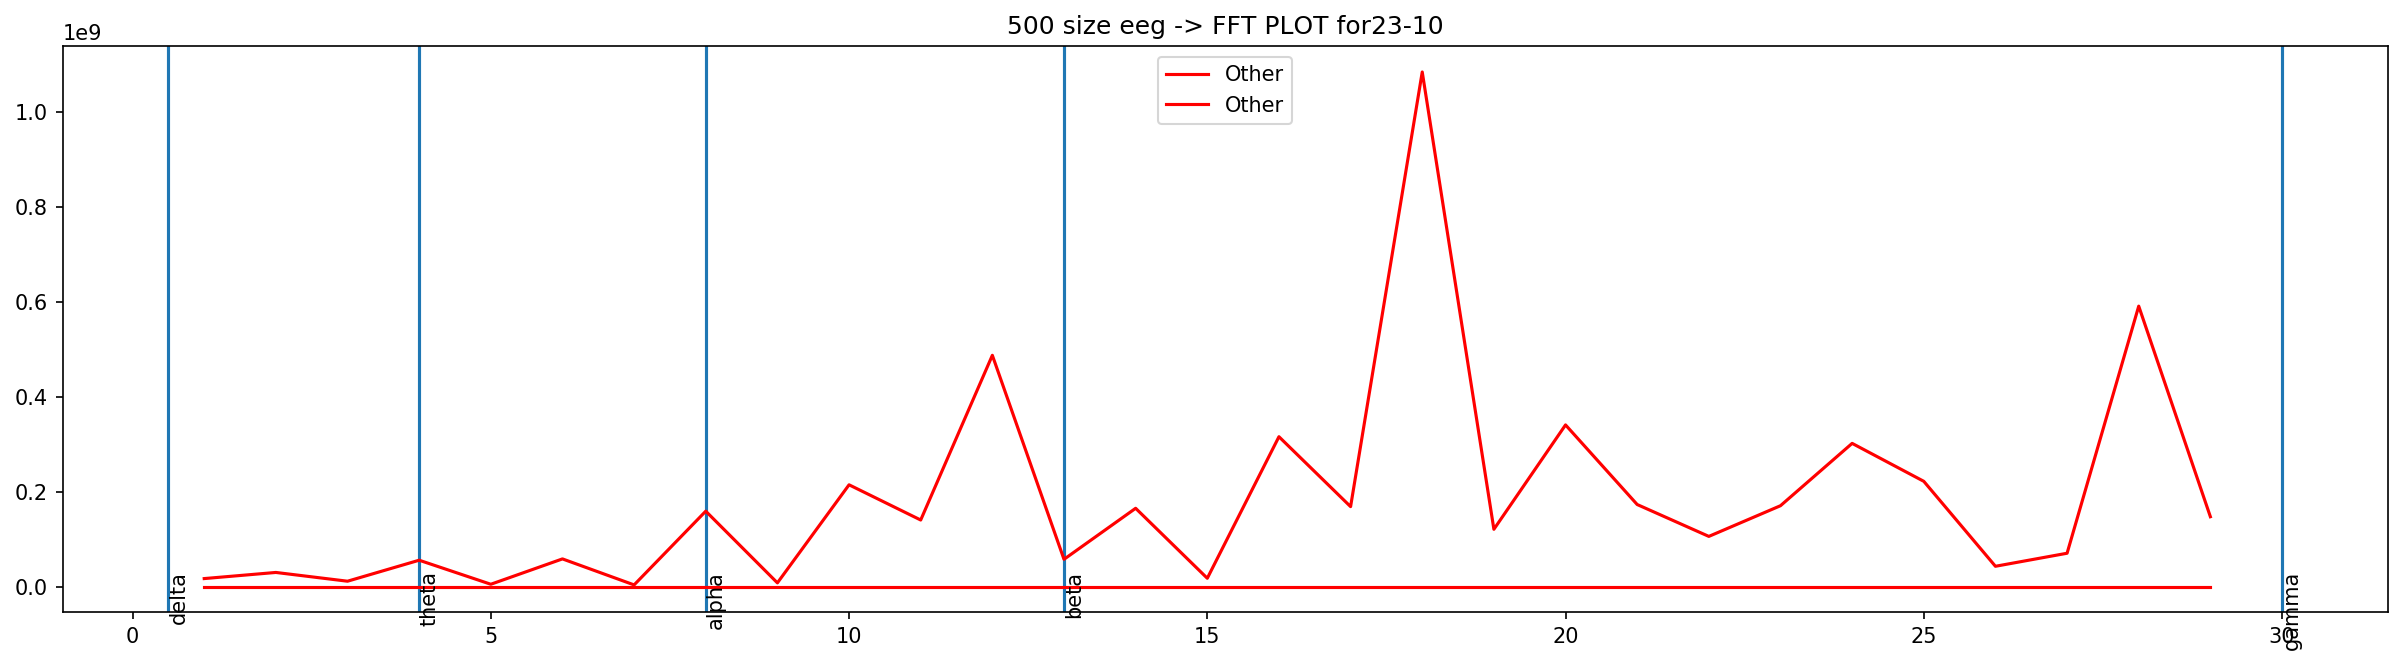

Date 24-10


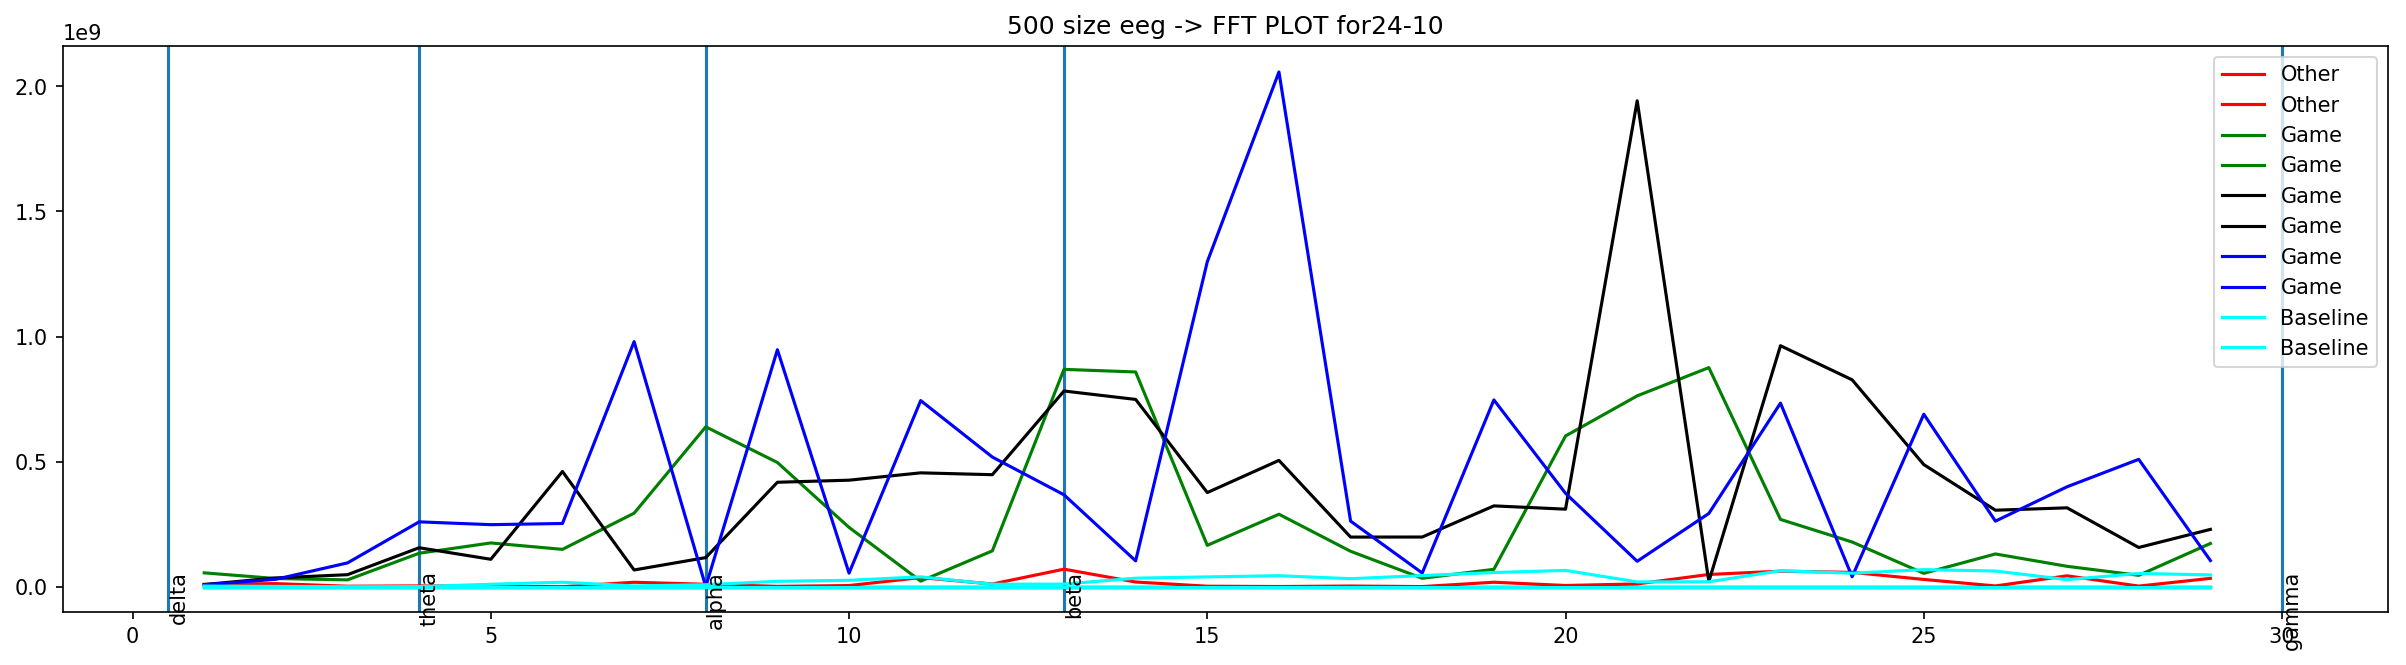

Date 27-10


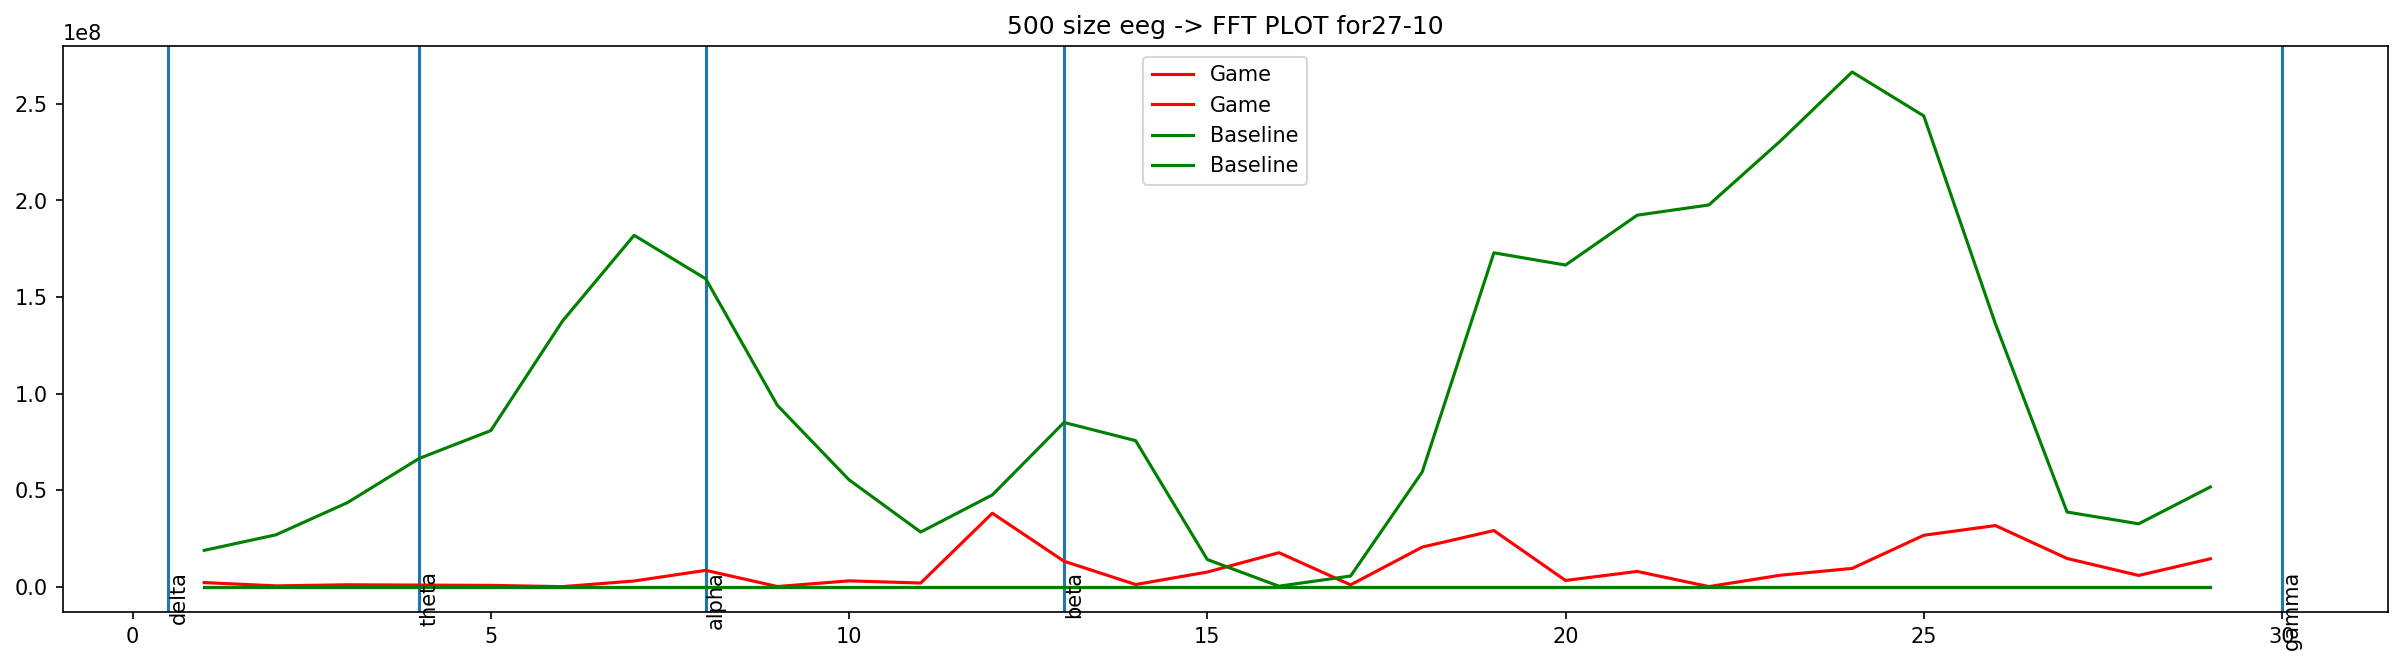

Date 28-10


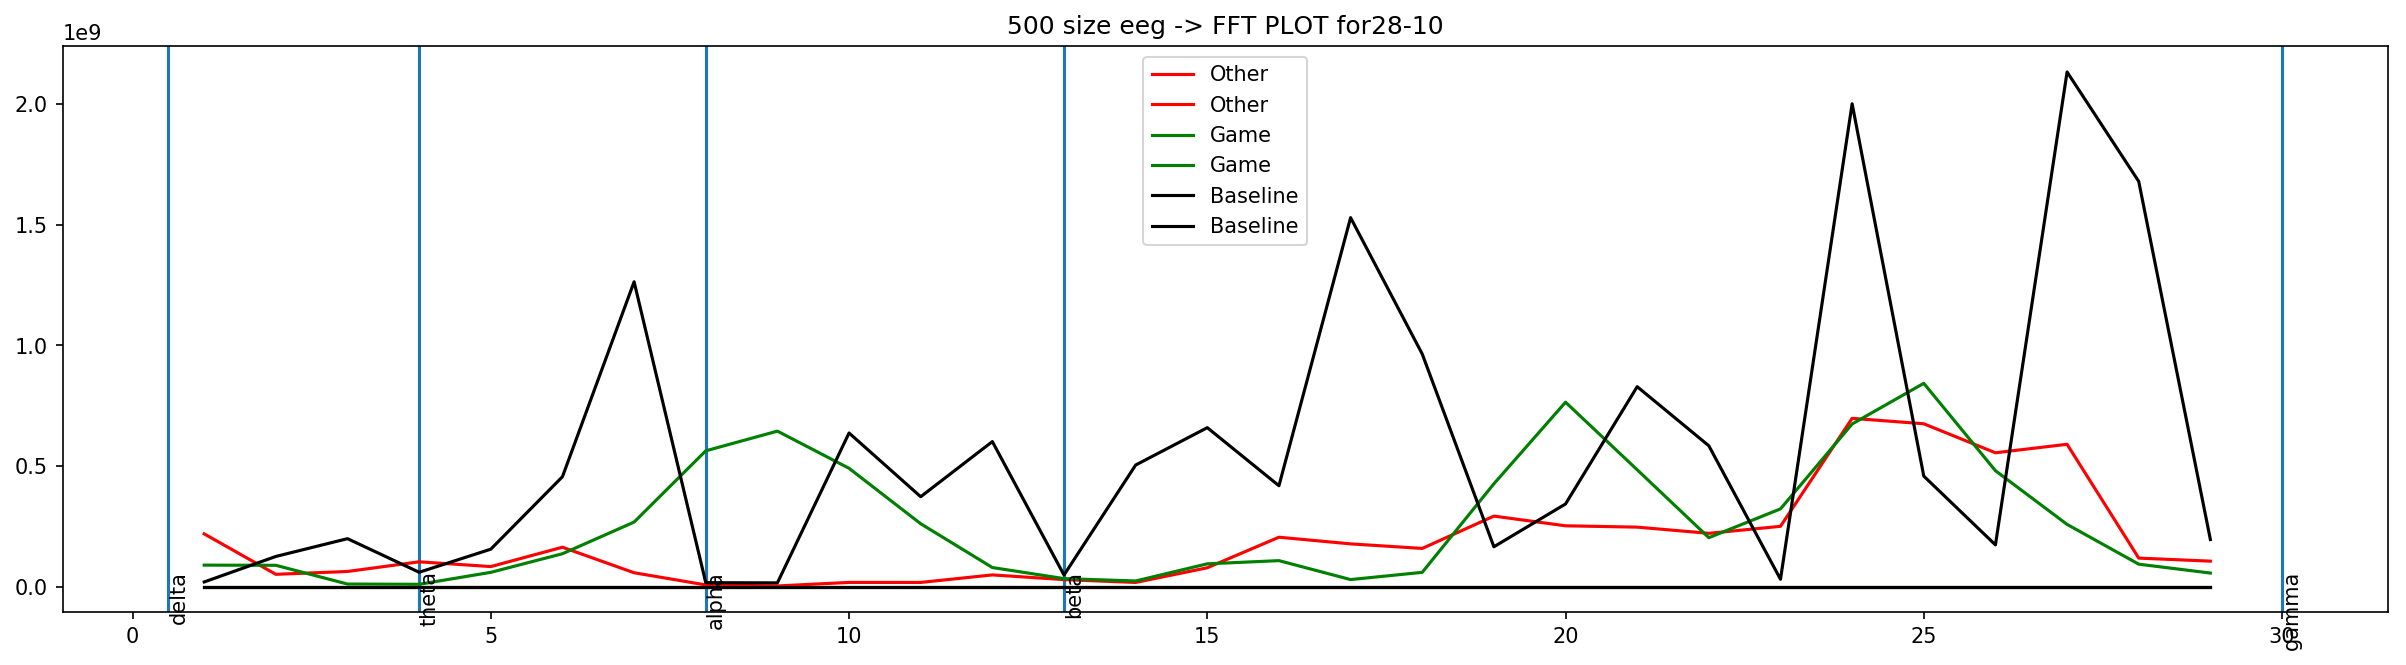

Date 29-10


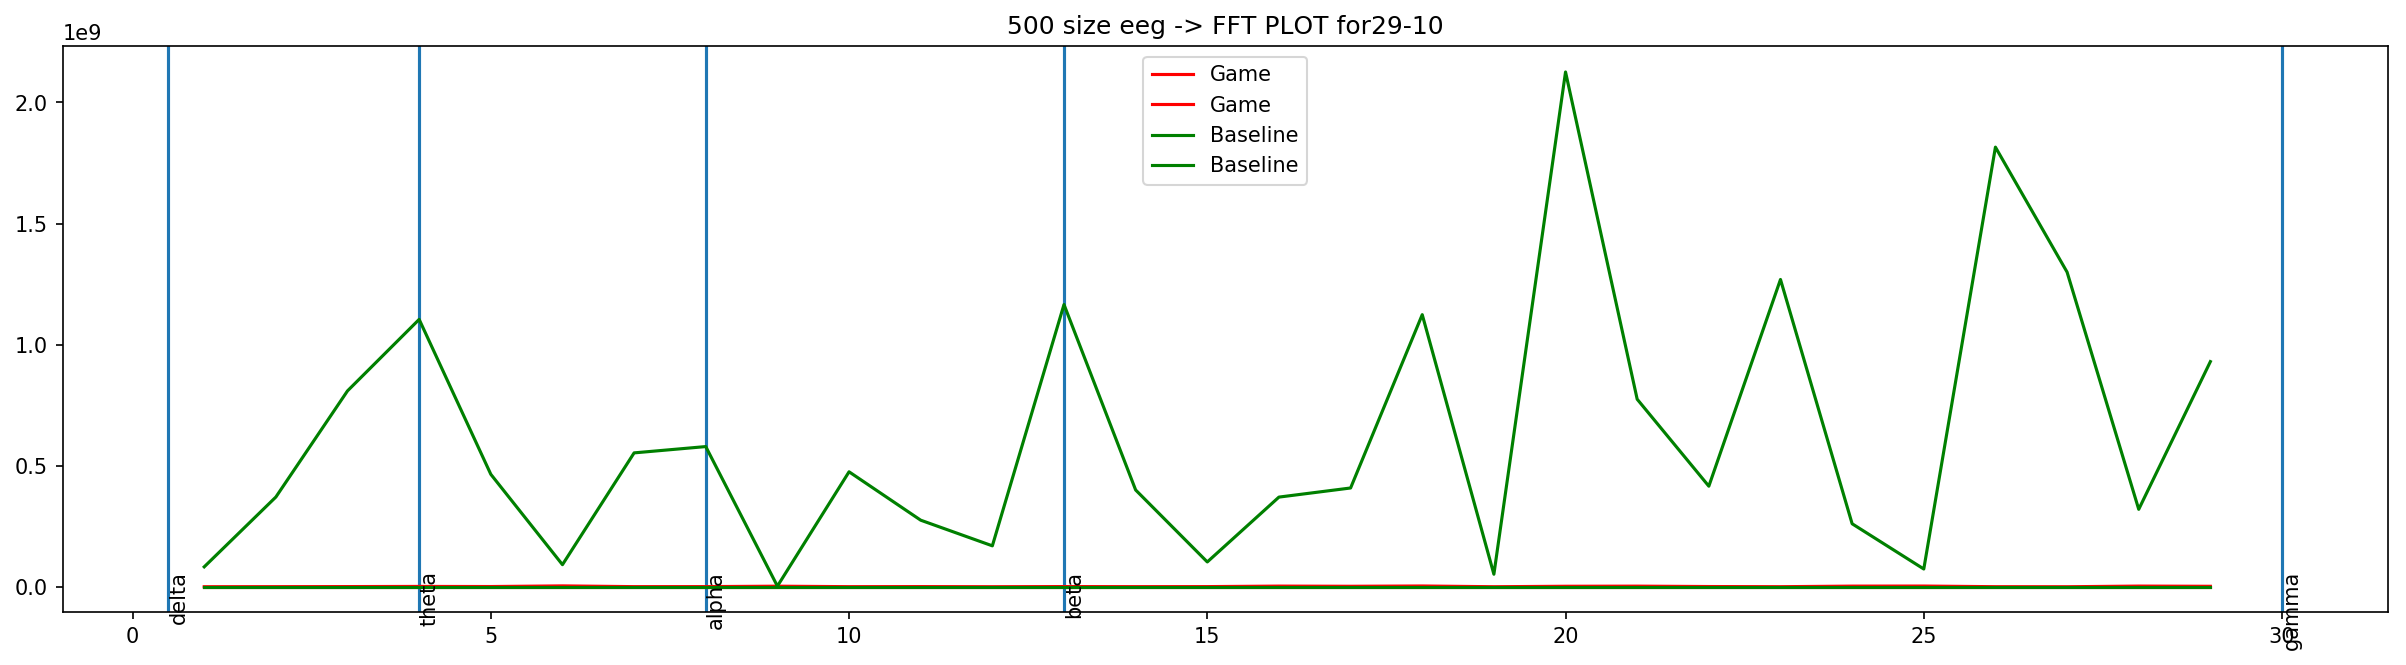

Date 30-10


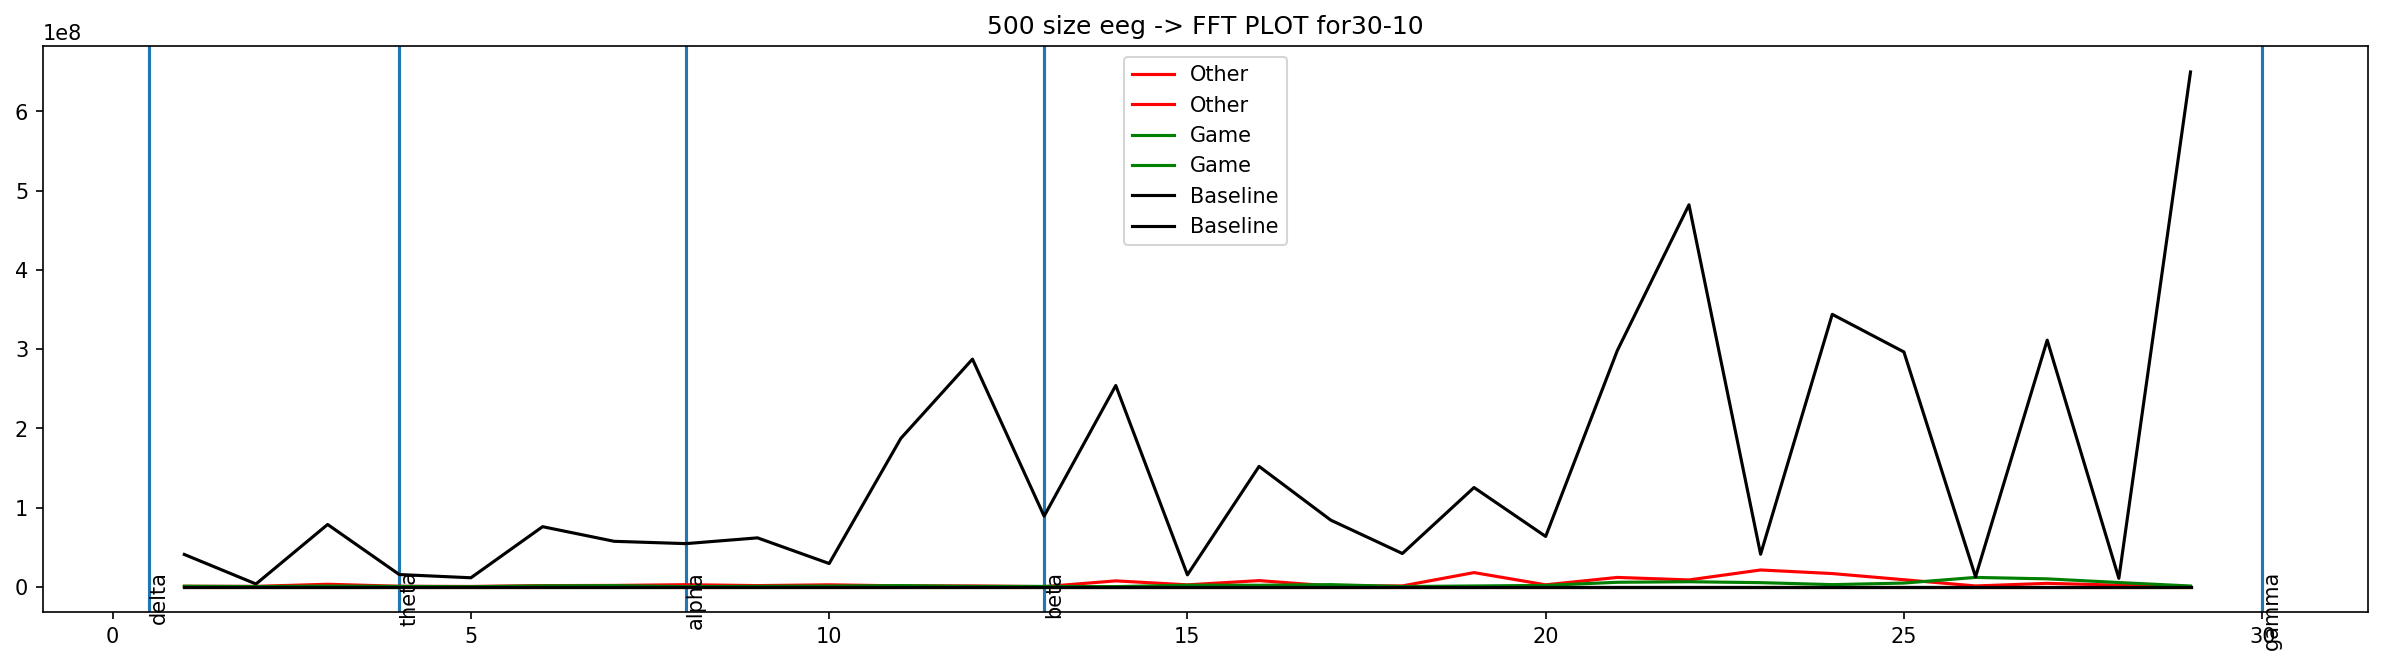

Date 31-10


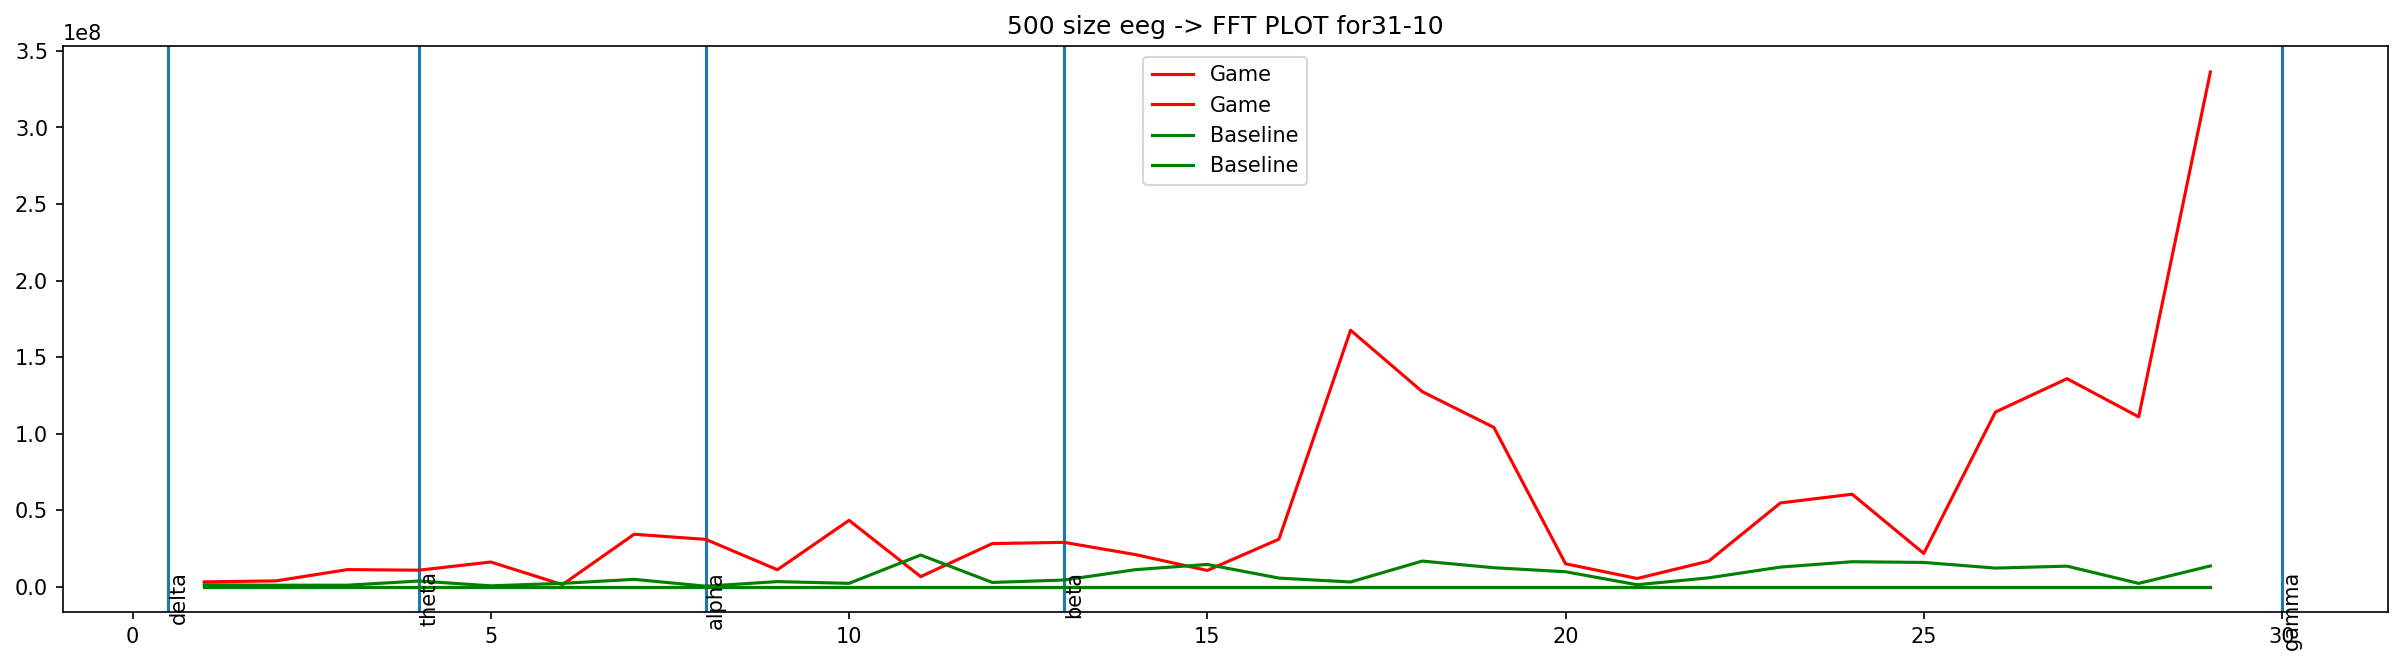

In [14]:
for date, group in dataset.groupby('date'): 
    print('Date', date)
#     print(type(date),type(group),group)
#     plot_eeg(group,date)
    plot_fft_eeg(group,date)


In [15]:
dataset.columns

Index(['eeg', 'activity', 'date', 'time', 'metadata'], dtype='object')

# lets us store second vector of each eeg in the  eeg_1 column of the dataset and find cosine similarity between them


In [16]:
dataset['eeg_1']=dataset['eeg'].apply(lambda x:x[1])

In [17]:
sample=dataset['eeg_1'].tolist()

In [18]:
s=np.array(sample)
s=s.reshape(len(dataset),500)

In [19]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


cosine_similarity(s[:5,:])

array([[ 1.        , -0.0156865 ,  0.053006  ,  0.03261868,  0.09229928],
       [-0.0156865 ,  1.        ,  0.04646422, -0.03987781,  0.15130389],
       [ 0.053006  ,  0.04646422,  1.        , -0.02332764,  0.03998313],
       [ 0.03261868, -0.03987781, -0.02332764,  1.        , -0.02823984],
       [ 0.09229928,  0.15130389,  0.03998313, -0.02823984,  1.        ]])

In [20]:
for activity, group in dataset.groupby(['activity']): 
    if activity in ["Baseline","Game"]:
        print('\n+++++++++++++++++++++++++++++++++++++')
        print('Activity:- ',activity)
        sample=group['eeg_1'].tolist()
        dates=group['date'].tolist()
        s=np.array(sample)
        s=s.reshape(len(group),500)
#         print(s)
        sim=cosine_similarity(s)
        print(sim)

#     print(type(date),type(group))



+++++++++++++++++++++++++++++++++++++
Activity:-  Baseline
[[ 1306  1265  1300 ...,   454  1233   643]
 [ -413  -171  -103 ...,  -281  -138   315]
 [    6    57    66 ...,    60    59    36]
 ..., 
 [  314  2047 -2048 ...,   -54    12    23]
 [ -369 -2048 -1134 ...,    -4    10    16]
 [  -57   -29     7 ...,    53    19    41]]
[[  1.00000000e+00   3.39494809e-02  -3.50259714e-03  -2.64881078e-02
    1.49713082e-02   2.74851034e-02   7.46362132e-03  -1.19768672e-02
   -1.15500299e-02   1.25930148e-02   9.79896292e-04   5.54654240e-02
    1.59110652e-02   2.28986414e-02  -6.49432353e-02  -9.55799684e-03]
 [  3.39494809e-02   1.00000000e+00   8.14330561e-02  -3.61323048e-02
    6.66364836e-02   9.00103960e-02   2.00981072e-02   8.92888945e-02
   -8.16715199e-02   1.19658702e-02   5.93541445e-02   1.25847315e-01
    4.09672156e-02   2.35025954e-02   1.07311869e-01   5.62548609e-02]
 [ -3.50259714e-03   8.14330561e-02   1.00000000e+00   4.46018487e-02
    1.44594968e-01   4.94123473e-02 